In [1]:
# importing modules and packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from io_utils import *
from plotting_utils import *
from analysis_utils import * 
from pathlib import Path
import pickle
import scipy
import seaborn as sns
import scipy.stats as stats
sns.set_context("talk")

In [2]:
animalsAgg = ['29L','3095','3096','3097','30B','30L','30R2','4013','4014','4015','4016','91R2'] # list of all aniamls
animalsObs = ['29L','30R2','86L', '87L2','927L','927R','933R'] # list of observer animals
animalsToy = ['583L2','583B','86L2', '87B', '87L','87R2'] # list of toy group animals
animalsAll = animalsAgg + animalsObs + animalsToy
groupsAll = ['agg' for i in range(len(animalsAgg))] + ['obs' for i in range(len(animalsObs))] + ['toy' for i in range(len(animalsToy))]
maxRegions = ['PrL (E)', 'PrL (I)', 'vLS (E)', 'vLS (I)', 'POA (E)', 'POA (I)', 'BNST (E)', 'BNST (I)', 'AH (E)', 'AH (I)', 'MeA (E)', 'MeA (I)', 'VMH (E)', 'VMH (I)', 'PAG (E)', 'PAG (I)', 'PMv (E)', 'PMv (I)', 'LHb (E)', 'LHb (I)', 'PA (E)', 'PA (I)', 'NAc (DA)']

featuresList = ["proximity","resident centroid roc 500 ms", "intruder centroid roc 500 ms", 'resident2intruder head-head', 'resident2intruder head-tti','resident2intruder head2head angle', 'resident2intruder head2tti angle', "intruder2resident head2centroid angle",
   "resident tti2head", "intruder tti2head", "resident tailbase2head angle", "intruder tailbase2head angle"]


In [3]:
Nbin = 20
indices_agg = list(range(len(animalsAgg)))
indices_obs = list(range(len(animalsAgg),len(animalsAgg)+len(animalsObs)))
indices_toy = list(range(len(animalsAgg)+len(animalsObs),len(animalsAgg)+len(animalsObs)+len(animalsToy)))

In [8]:
W_map_all = np.ma.empty((len(animalsAll), len(maxRegions), len(featuresList), Nbin+1), dtype=float)
W_map_all.mask = True
W_map_group = np.ma.empty((len(animalsAll), len(maxRegions), len(featuresList), Nbin+1), dtype=float)
W_map_group.mask = True
best_alpha_all = np.ma.empty((len(animalsAll), len(maxRegions), len(featuresList)), dtype=float)
best_alpha_all.mask = True
best_alpha_group = np.ma.empty((len(animalsAll), len(maxRegions), len(featuresList)), dtype=float)
best_alpha_group.mask = True
r2_animal_test_all = np.ma.empty((len(animalsAll), len(maxRegions), len(featuresList)), dtype=float)
r2_animal_test_all.mask = True
r2_animal_test_group = np.ma.empty((len(animalsAll), len(maxRegions), len(featuresList)), dtype=float)
r2_animal_test_group.mask = True
mse_animal_test_all = np.ma.empty((len(animalsAll), len(maxRegions), len(featuresList)), dtype=float)
mse_animal_test_all.mask = True
mse_animal_test_group = np.ma.empty((len(animalsAll), len(maxRegions), len(featuresList)), dtype=float)
mse_animal_test_group.mask = True

for ind in range(len(animalsAll)):
    animal_without = animalsAll[ind]
    group_without = groupsAll[ind]

    df = load_and_wrangle(mouseId=animal_without, group=group_without, path=None, overwrite=False)
    regions = get_regions_dataframe(df)
    for region in regions:
        region_ind = maxRegions.index(region)
        # np.load(f'../data/{animal_without}/{animal_without}_{group_without}_test_MAP-estimation_day9_region={region}.npz')
        data = np.load(f'../data/{animal_without}/{animal_without}_{group_without}_test_MAP-estimation_day9_region={region}.npz', allow_pickle=True)
        W_map1 = data['W_map_all']
        W_map2 = data['W_map_group']
        best_alpha_all[ind, region_ind] = data['best_alpha_all']
        best_alpha_group[ind, region_ind] = data['best_alpha_group']
        r2_animal_test_all[ind, region_ind] = data['r2_animal_test_all']
        r2_animal_test_group[ind, region_ind] = data['r2_animal_test_group']
        mse_animal_test_all[ind, region_ind] = data['mse_animal_test_all']
        mse_animal_test_group[ind, region_ind] = data['mse_animal_test_group']
        
        for ind_feature in range(len(featuresList)):
            W_map_all[ind,region_ind,ind_feature] = W_map1[ind_feature]
            W_map_group[ind,region_ind,ind_feature] = W_map2[ind_feature]

In [5]:
groups_flag = [0 for i in range(len(animalsAgg))] + [1 for i in range(len(animalsObs))] + [2 for i in range(len(animalsToy))]
label_dict = {0:'agg',1:'obs',2:'toy'}
color_dict = {0:'tab:red',1:'tab:blue',2:'tab:green'}
w_dict = {0: W_map_group[indices_agg, :, :, :], 1:W_map_group[indices_obs, :, :, :], 2:W_map_group[indices_toy, :, :, :]}

In [10]:
r2_pairwise = np.load(f'../data/r2_pairwise_groups', allow_pickle=True)
mse_pairwise = np.load(f'../data/mse_pairwise_groups', allow_pickle=True)

good_models_indices = np.zeros((3, len(maxRegions), len(featuresList)))
for group_flag in [0,1,2]:
    count = 0
    indices_group = np.argwhere(np.array(groups_flag) == group_flag).flatten()
    for region_ind in range(len(maxRegions)):
        for feature_ind in range(len(featuresList)):
            if r2_pairwise[group_flag, group_flag, indices_group, region_ind, feature_ind].mean(axis=0) >= 0:
                for group_other in [0,1,2]:
                    if group_other != group_flag:
                        t, p = stats.ttest_rel(r2_pairwise[group_flag, group_flag, indices_group, region_ind, feature_ind], r2_pairwise[group_flag, group_other, indices_group, region_ind, feature_ind], alternative='greater')
                        if p < 0.05:
                            print(label_dict[group_other])
                            print(maxRegions[region_ind])
                            print(featuresList[feature_ind])

    # print(np.sort(r2_pairwise[group_flag, group_flag, indices_group, :, :].flatten())[::-1])

obs
PMv (E)
proximity
toy
PMv (E)
proximity
obs
PMv (E)
resident2intruder head-head
toy
PMv (E)
resident2intruder head-head
obs
PMv (E)
resident2intruder head-tti
toy
PMv (E)
resident2intruder head-tti
toy
PrL (E)
resident centroid roc 500 ms
agg
PMv (E)
proximity
agg
PMv (E)
resident2intruder head-head
agg
AH (I)
proximity
obs
AH (I)
proximity
agg
AH (I)
resident2intruder head-head
obs
AH (I)
resident2intruder head-head
agg
AH (I)
resident2intruder head-tti
obs
AH (I)
resident2intruder head-tti
agg
PMv (E)
proximity
obs
PMv (E)
proximity
agg
PMv (E)
resident2intruder head-head
obs
PMv (E)
resident2intruder head-head
agg
PMv (E)
resident2intruder head-tti
obs
PMv (E)
resident2intruder head-tti


In [32]:
# Pairwise comparison between groups
# significance test for day 9 - done separately for each region and feature

r2_pairwise = np.load(f'../data/r2_pairwise_groups', allow_pickle=True)
mse_pairwise = np.load(f'../data/mse_pairwise_groups', allow_pickle=True)

curves_significant = np.zeros((3, 3, len(maxRegions), len(featuresList))).astype(int)

count = 0
for [group_flag, group_other] in [[0,1],[1,0],[0,2],[2,0],[1,2],[2,1]]:
    count = 0
    indices_group = np.argwhere(np.array(groups_flag) == group_flag).flatten()
    # print(r2_pairwise)
    for region_ind in range(len(maxRegions)):
        for feature_ind in range(len(featuresList)):
            # print(mse_pairwise[group_flag, group_flag, indices_group, region_ind, feature_ind])
            # print(mse_pairwise[group_flag, group_other, indices_group, region_ind, feature_ind])

            # print(r2_pairwise[group_flag, group_flag, indices_group, region_ind, feature_ind])
            # print(r2_pairwise[group_flag, group_other, indices_group, region_ind, feature_ind])
            # t1, p1 = stats.ttest_rel(mse_pairwise[group_flag, group_flag, indices_group, region_ind, feature_ind], mse_pairwise[group_flag, group_other, indices_group, region_ind, feature_ind], alternative='less')
            # t2, p2 = stats.ttest_rel(r2_pairwise[group_flag, group_flag, indices_group, region_ind, feature_ind], r2_pairwise[group_flag, group_other, indices_group, region_ind, feature_ind], alternative='greater')
            
            # # print(t)
            # if (p2<0.05): 
            #     count += 1
            #     print('mse t = ',np.round(t,3))
            #     # print(mse_pairwise[group_flag, group_flag, indices_group, region_ind, feature_ind].mean())
            #     # print(mse_pairwise[group_flag, group_other, indices_group, region_ind, feature_ind].mean())
            #     curves_significant[group_flag, group_other, region_ind, feature_ind] = 1

    # print(count)

55
16
108
19
31
7


NameError: name 'curves_significant' is not defined

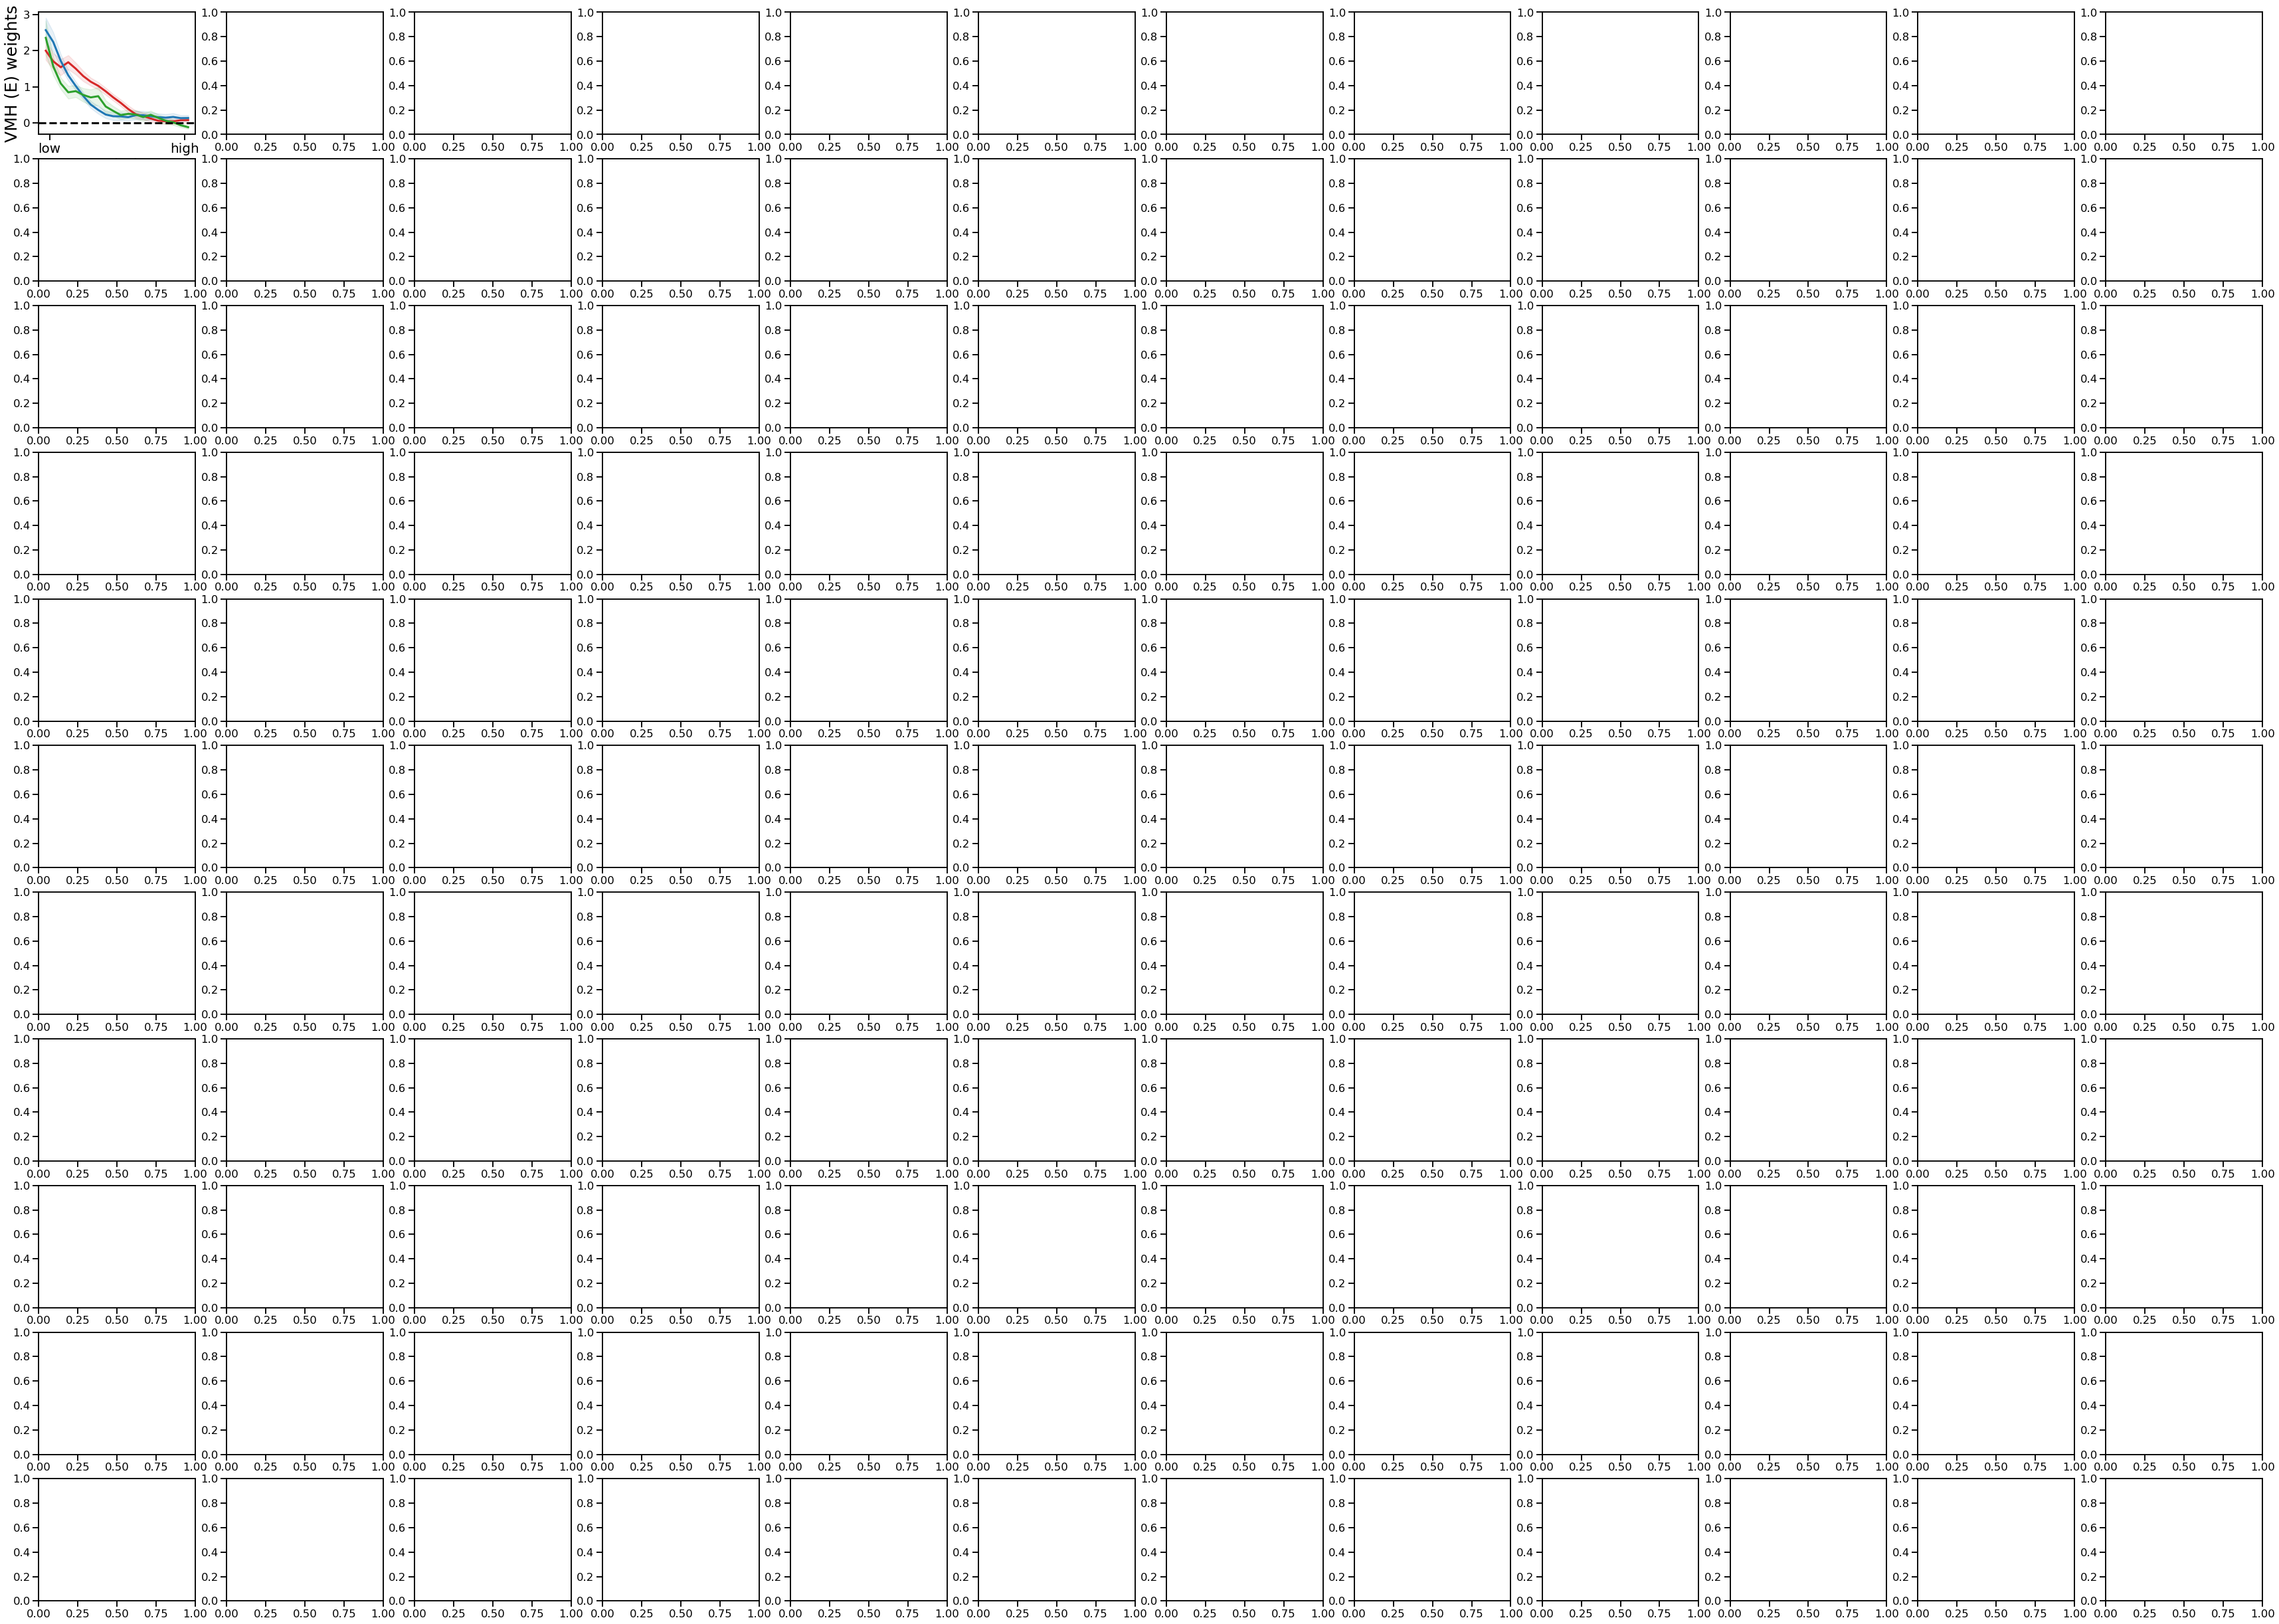

In [11]:
# plots of tuning curves for day 9

from scipy.stats import ttest_ind, ttest_rel
# regionsInterest = [0,1,2,3,4,5,6,7,8,9,10,11] #ind_sort[0:13]#[0,1,2,3,4,5,6,7,8,9,10,11]
# set = 1
regionsInterest = [12,13,14,15,16,17,18,19,20,21,22]
set = 2

featuresInterest_index = [0,3,4,1,2]

fig, axes = plt.subplots(nrows=len(regionsInterest), ncols=len(featuresList), figsize=(5 * len(featuresList), 4 * len(regionsInterest)))
b = 0
for feature_ind in featuresInterest_index:

    c = 0
    for region_ind in regionsInterest:
        
        # axes[b,c].plot(W_map_all[:,region_ind, feature_ind, 1:].mean(axis=0), color='black', label=f'global', linewidth=3)
        for i in range(3):
            w_group = w_dict[i][:, region_ind, feature_ind, 1:]
            axes[c,b].plot(w_group.mean(axis=0), color=color_dict[i], label=label_dict[i], linewidth=3)
            axes[c,b].fill_between(range(20),  w_group.mean(axis=0) - w_group.std(axis=0), w_group.mean(axis=0) + w_group.std(axis=0), alpha=0.1, color=color_dict[i]) 

        axes[c,b].axhline(0, color = 'black', ls = 'dashed', linewidth=3) 
        axes[c,b].set_xticks([0.5,18.5],['low','high'], size=20)
        axes[c,0].set_ylabel(f'{maxRegions[region_ind]} weights', size=25)
        axes[c,b].set_xlabel(featuresList[feature_ind],size=23)

        title = ''
        if curves_significant[0, 1, region_ind,feature_ind] + curves_significant[1, 0, region_ind,feature_ind] > 0:
            title = title + ' agg != obs '
        if curves_significant[0, 2, region_ind,feature_ind] + curves_significant[2, 0, region_ind,feature_ind] > 0:
            title = title + ' agg != toy '
        if curves_significant[1, 2, region_ind,feature_ind] + curves_significant[2, 1, region_ind,feature_ind] > 0:
            title = title + ' obs != toy '
        if title != '':
            axes[c,b].spines['left'].set_linewidth(5)
            axes[c,b].spines['right'].set_linewidth(5)
            axes[c,b].spines['top'].set_linewidth(5)
            axes[c,b].spines['bottom'].set_linewidth(5)
        else:
             axes[c,b].spines[['right', 'top']].set_visible(False)
        axes[c,b].set_title(title)

    
        if feature_ind == 0:
            # axes[b,c].set_ylim(-1.2,1.2)
            axes[c,b].set_xlabel('proximity',size=23)
            axes[c,b].set_xticks([0.5,18.5],['close','far'], size=20)
        elif feature_ind == 1:
            # axes[b,c].set_ylim(-0.3,1.3)
            axes[c,b].set_xlabel('resident speed',size=23)
        elif feature_ind == 2:
            # axes[b,c].set_ylim(-0.3,1)
            axes[c,b].set_xlabel('intruder speed',size=23)
        elif feature_ind == 3:
            # axes[b,c].set_ylim(-0.5,0.6)
            axes[c,b].set_xlabel('res2intr head-head distance',size=23)
            axes[c,b].set_xticks([0.5,18.5],['close','far'], size=20)
        elif feature_ind == 4:
            # axes[b,c].set_ylim(-0.5,0.8)
            axes[c,b].set_xlabel('res2intr head-tti distance',size=23) 
            axes[c,b].set_xticks([0.5,18.5],['close','far'], size=20)
        elif feature_ind == 5:
            # axes[b,c].set_ylim(-0.4,0.4)
            axes[c,b].set_xlabel('res2intr head-head angle',size=23)
        elif feature_ind == 6:
            # axes[b,c].set_ylim(-0.4,0.35)
            axes[c,b].set_xlabel('res2intr head-tti angle',size=23)
        elif feature_ind == 7:
            # axes[b,c].set_ylim(-0.25,0.25)
            axes[c,b].set_xlabel('intr2res head-centroid angle',size=23)
        elif feature_ind == 8:
            # axes[b,c].set_ylim(-0.5,0.8)
            axes[c,b].set_xlabel(featuresList[feature_ind],size=23)
        elif feature_ind == 9:
            # axes[b,c].set_ylim(-0.25,0.4)
            axes[c,b].set_xlabel(featuresList[feature_ind],size=23)
        
        axes[0,0].legend(loc=(1.02,0.2))
        # axes[b,c].set_ylim(-1,1.4)

        # # last day
        # axes[feature_ind].plot(W_map[feature_ind, Nday_ind][1:], color='black', label=f'Test - Day 9')
        # axes[feature_ind].set_xlabel(featuresLonglist[feature_ind])  
        c += 1 
    # axes[c-1,-1].legend(loc=(1.02,0.2))
    b += 1
    # fig.suptitle('Aggression group: ' + featuresLonglist[feature_ind], size=25, y=1.02)
fig.tight_layout()
plt.savefig(f'../figures/TuningCurves_Groups_Day-9_Set={set}.png', dpi=400)

In [7]:
# # Pairwise comparison between groups
# r2_pairwise = np.ma.empty((3, 3, len(animalsAll), len(maxRegions), len(featuresList)), dtype=float) # agg=0, obs=1, toy=2 groups in that order
# r2_pairwise.mask = True
# mse_pairwise = np.ma.empty((3, 3, len(animalsAll), len(maxRegions), len(featuresList)), dtype=float)
# mse_pairwise.mask = True

# for ind in range(len(animalsAll)):
#     animal_without = animalsAll[ind]
#     group_without = groupsAll[ind]
#     group_flag = groups_flag[ind]
#     print(animal_without)
    
#     temp_df = load_and_wrangle(mouseId=animal_without, group=group_without, path=None, overwrite=False)
#     temp_df = temp_df[temp_df['day']=='d9'] # only day 9
#     regions = get_regions_dataframe(temp_df)

#     for region in regions: 
#         region_ind = maxRegions.index(region)
        
#         Y_animal_test = np.array(temp_df[region])

#         # performance on curve for group (without test animal)
#         r2_pairwise[group_flag, group_flag, ind, region_ind] = r2_animal_test_group[ind, region_ind, :]
#         mse_pairwise[group_flag, group_flag, ind, region_ind] = mse_animal_test_group[ind, region_ind, :]
#         for feature_ind in range(len(featuresList)):
#             features = [featuresList[feature_ind]]
        
#             X_animal_test,_ = get_design_day9_X_GLM_features(animal_without, group=group_without, features=features, Nbins=Nbin, path=None)
#             for group_other in [0,1,2]:
#                 if group_other != group_flag:
#                     r2_pairwise[group_flag, group_other, ind, region_ind] = compute_r_squared(X_animal_test, Y_animal_test, w_dict[group_other][region_ind, feature_ind])
#                     mse_pairwise[group_flag, group_other, ind, region_ind] = mse(X_animal_test, Y_animal_test, w_dict[group_other][region_ind, feature_ind])

# r2_pairwise.dump(f'../data/r2_pairwise_groups')
# mse_pairwise.dump(f'../data/mse_pairwise_groups')


In [ ]:
# CHECK WHICH ARE GOOD FITS IN ABSOLUTE TERMS

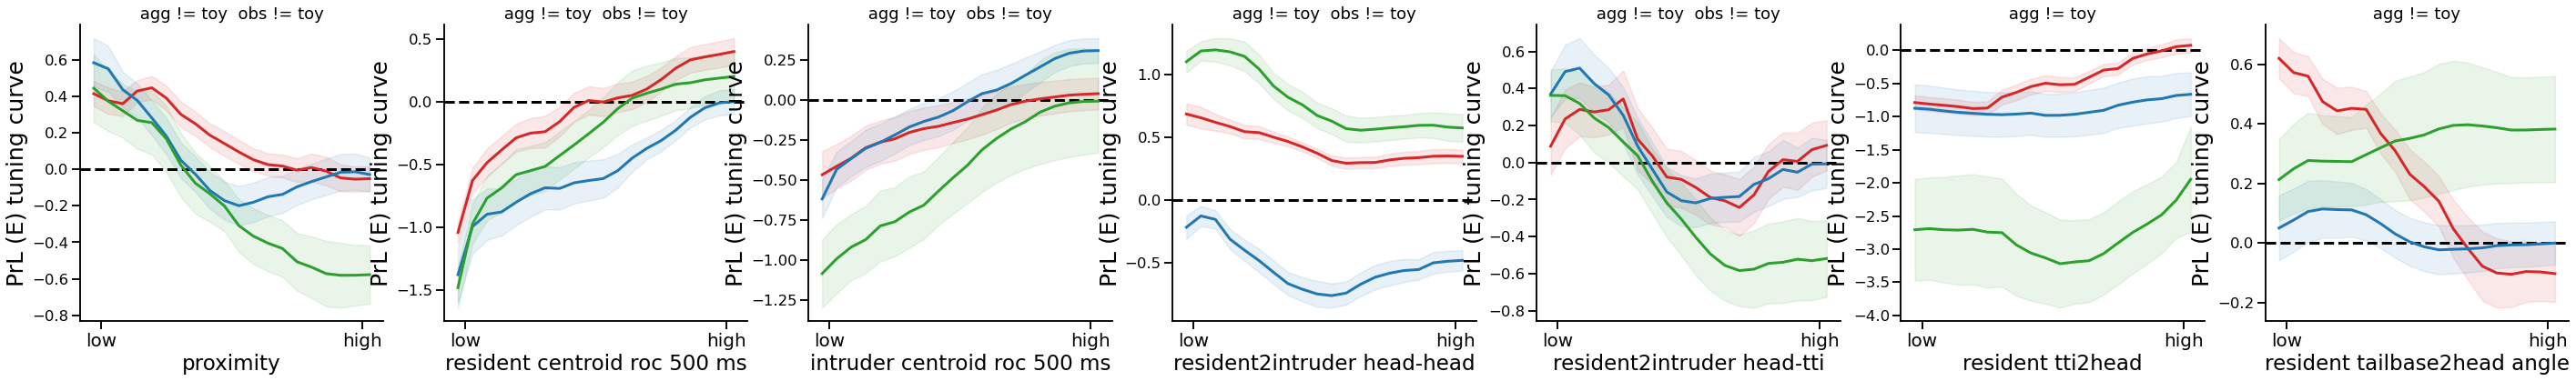

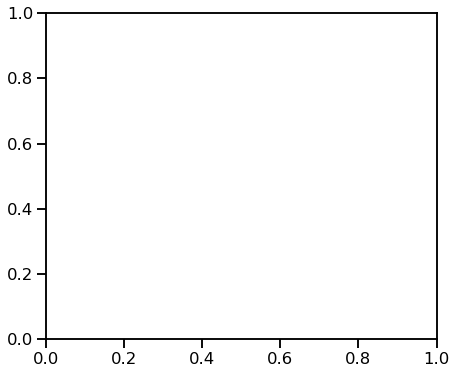

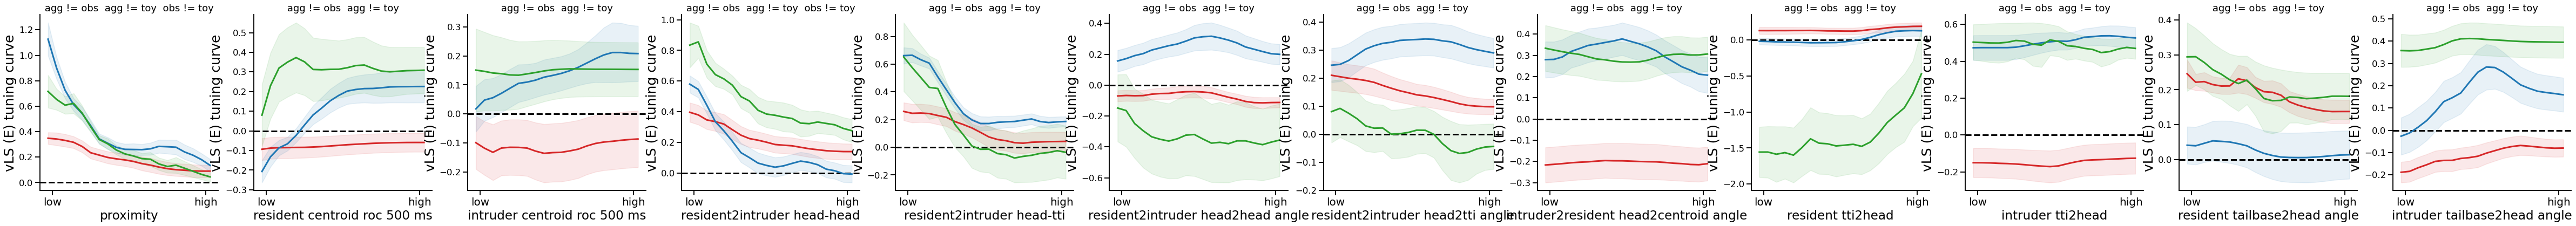

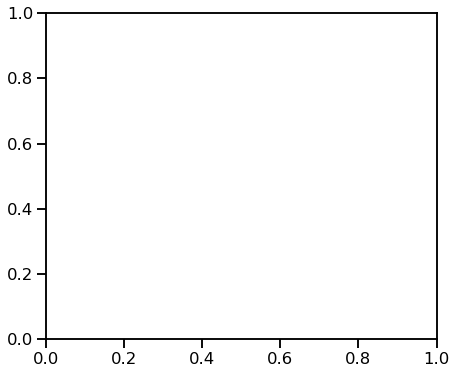

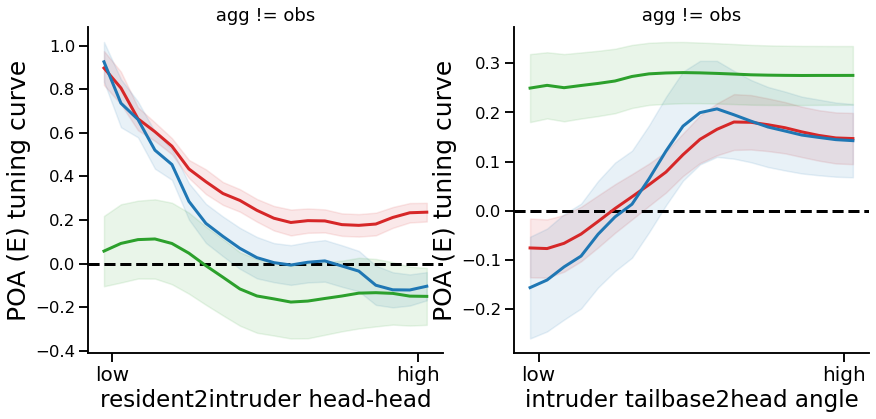

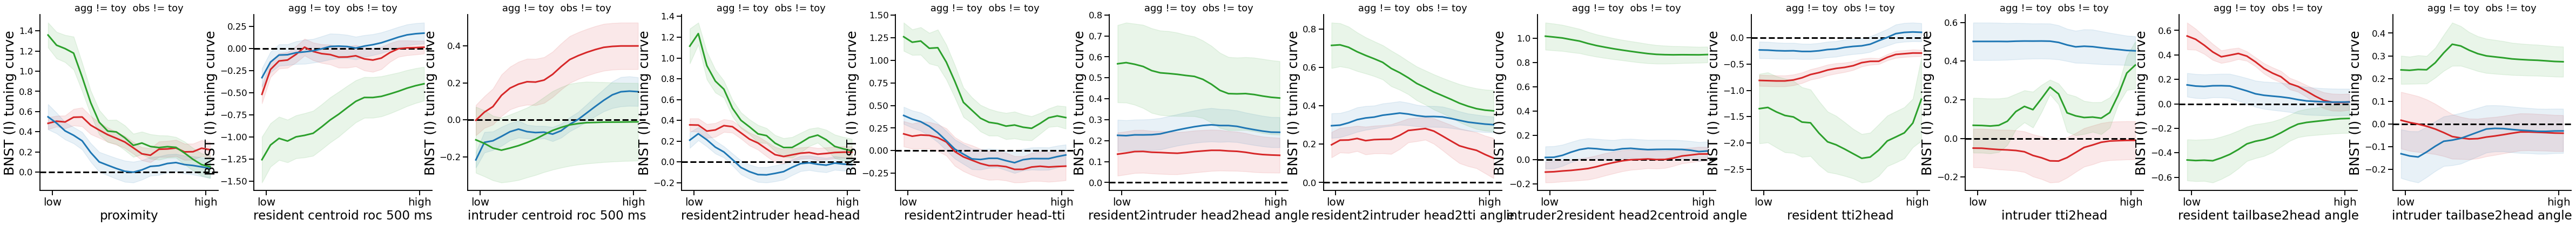

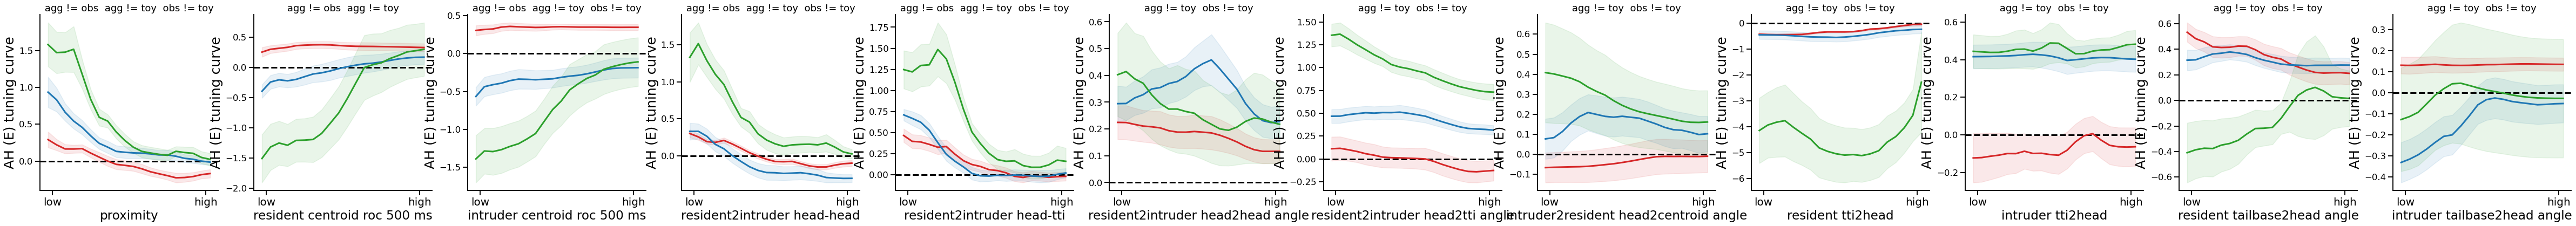

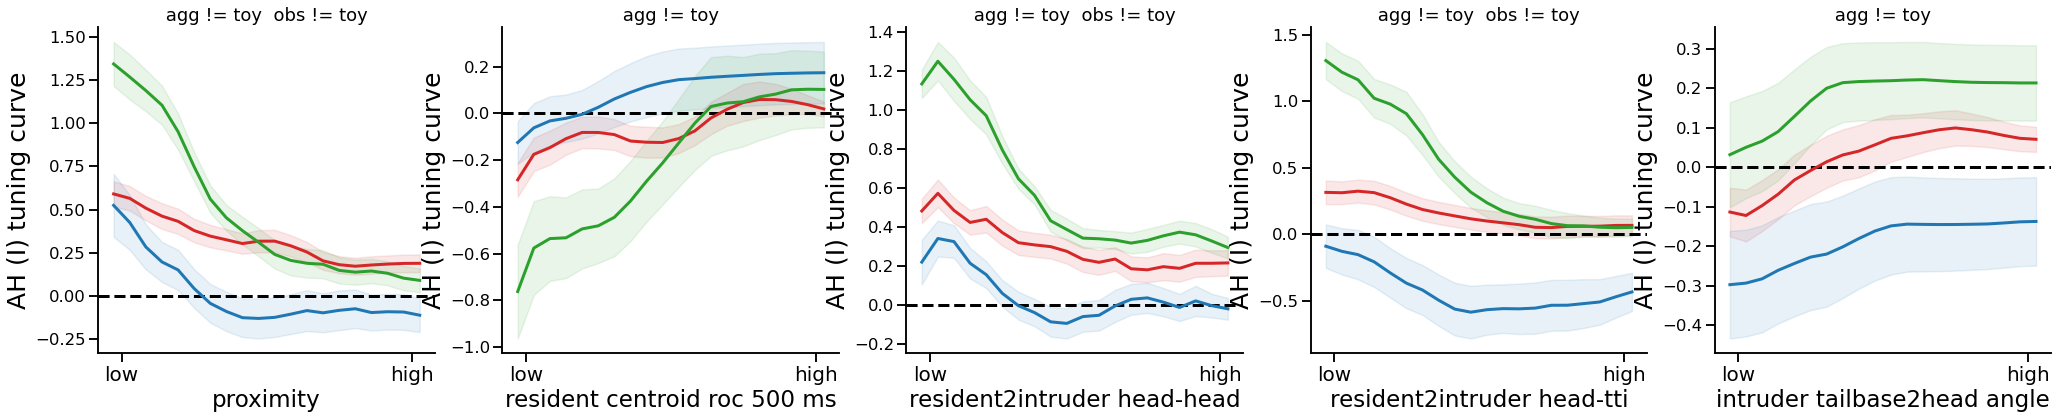

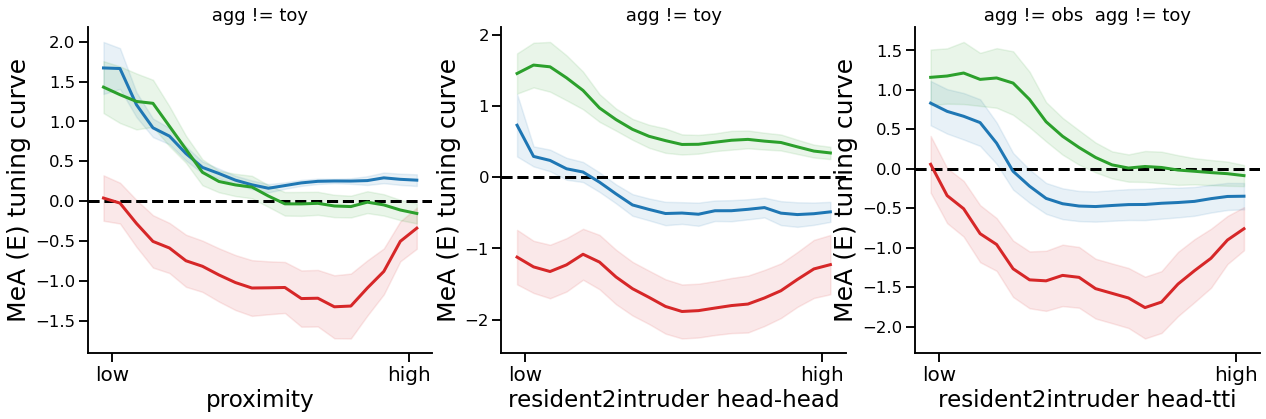

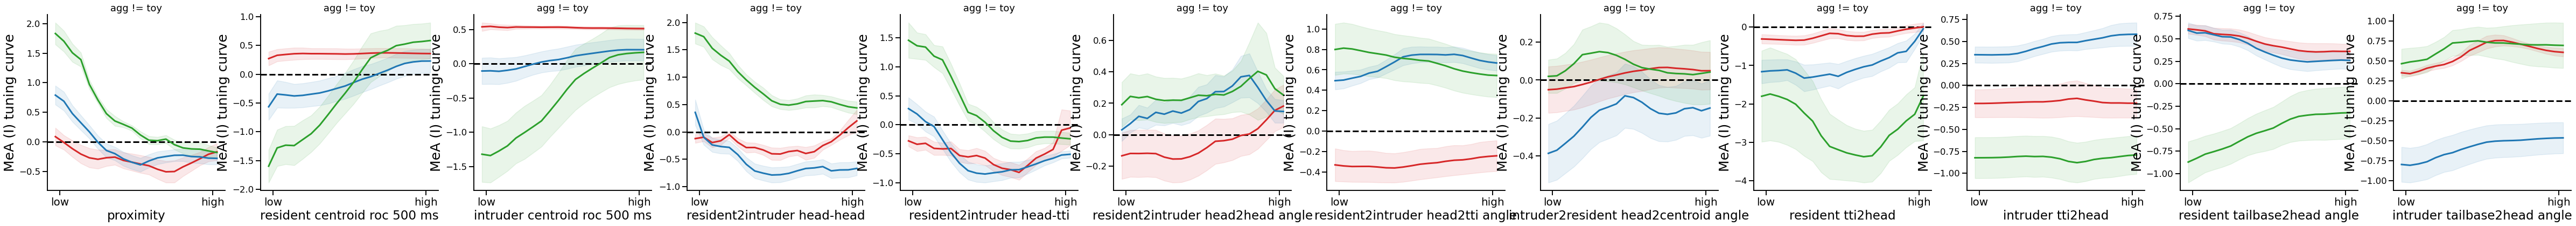

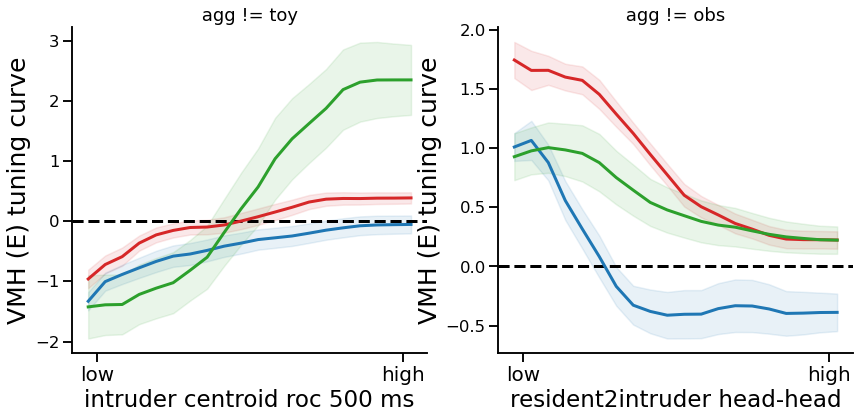

IndexError: list index out of range

In [74]:
# BETTER FOR GROUP
for region_ind in range(len(maxRegions)):
    indices_significant_any = []
    for [group_flag, group_other] in [[0,1],[0,2],[1,2]]:
        indices_significant1 = list(np.array(np.argwhere(curves_significant[group_flag, group_other,region_ind,:] == 1)).flatten())
        indices_significant2 = list(np.array(np.argwhere(curves_significant[group_other, group_flag,region_ind,:] == 1)).flatten())
        indices_significant_either = indices_significant1 + [x for x in indices_significant2 if x not in indices_significant1]
        indices_significant_any = indices_significant_either + [x for x in indices_significant_any if x not in indices_significant_either]
        indices_significant_any.sort()
        count_significant = len(indices_significant_any)
    if count_significant > 0:
        for feature_ind in range(count_significant):
            # treshold to describe aggression decently
            if r2_pairwise[0,0,:,region_ind,indices_significant_any[feature_ind]].mean(axis=-1) < -0.5:
                indices_significant_any.remove(indices_significant_any[feature_ind])
    count_significant = len(indices_significant_any)
    if count_significant > 0:
        if count_significant == 1:
            fig, axes = plt.subplots(figsize=(7, 6))
            feature_ind = 0
        else:
            fig, axes = plt.subplots(nrows=1, ncols=count_significant, figsize=(7 * count_significant, 6))
            for feature_ind in range(count_significant):
                    # print(featuresList[feature_ind])
                title = ''
                if curves_significant[0, 1, region_ind,indices_significant_any[feature_ind]] + curves_significant[1, 0, region_ind,indices_significant_any[feature_ind]] > 0:
                    title = title + ' agg != obs '
                if curves_significant[0, 2, region_ind,indices_significant_any[feature_ind]] + curves_significant[2, 0, region_ind,indices_significant_any[feature_ind]] > 0:
                    title = title + ' agg != toy '
                if curves_significant[1, 2, region_ind,indices_significant_any[feature_ind]] + curves_significant[2, 1, region_ind,indices_significant_any[feature_ind]] > 0:
                    title = title + ' obs != toy '
                axes[feature_ind].set_title(title)
                axes[feature_ind].axhline(0, color = 'black', ls = 'dashed', linewidth=3)

                for i in range(3):
                    w_group = w_dict[i][:, region_ind, indices_significant_any[feature_ind], 1:]
                    axes[feature_ind].plot(w_group.mean(axis=0), color=color_dict[i], label=label_dict[i], linewidth=3)
                    axes[feature_ind].fill_between(range(20),  w_group.mean(axis=0) - w_group.std(axis=0), w_group.mean(axis=0) + w_group.std(axis=0), alpha=0.1, color=color_dict[i]) 
             
                axes[feature_ind].set_xticks([0.5,18.5],['low','high'], size=20)
                axes[feature_ind].set_ylabel(f'{maxRegions[region_ind]} tuning curve', size=25)
                # axes.set_title(f'{maxRegions[region_ind]} - Day 9 (CD1)', weight='bold', size=25)
                axes[feature_ind].spines[['right', 'top']].set_visible(False)
                axes[feature_ind].set_xlabel(featuresList[indices_significant_any[feature_ind]],size=23)
            plt.show()


In [95]:
# significance test for day 9 - done separately for each region and feature
curves_group_better = np.zeros((len(maxRegions), len(featuresList))).astype(int)
curves_global_better = np.zeros((len(maxRegions), len(featuresList))).astype(int)
count = 0
for feature_ind in featuresInterest_index:
    # print(featuresList[feature_ind])
    for region_ind in range(len(maxRegions)):
        # print(maxRegions[region_ind])
        
        # CHECKHOW NANS ARE HANDLED
        # print((r2_animal_test_all[anim, region_ind, feature_ind]))
        # print((r2_animal_test_group[:, region_ind, feature_ind]))

        # # r2 testing
        # t, p = stats.ttest_rel(r2_animal_test_all[indices_agg, region_ind, feature_ind],r2_animal_test_group[indices_agg, region_ind, feature_ind])
        # # t, p = stats.ttest_rel(r2_animal_test_all[indices_agg, region_ind, feature_ind],r2_animal_test_group[indices_agg, region_ind, feature_ind], alternative='less')
        # if (p < 0.05): # r2 (error) for r2_animal_test_all if t > 0
        #     count += 1
        # # print(t)
        #     # print(featuresList[feature_ind])
        #     # print(maxRegions[region_ind])
        #     print('r2 t = ',np.round(t,3))
        #     print('Global model: r2 = ', r2_animal_test_all[:, region_ind, feature_ind].mean())
        #     print('Group model: r2 = ', r2_animal_test_group[:, region_ind, feature_ind].mean())
        #     curves_significant[region_ind,feature_ind] = 1
            
        
        # mse testing
        t, p = stats.ttest_rel(mse_animal_test_all[:, region_ind, feature_ind],mse_animal_test_group[:, region_ind, feature_ind])
        # t, p = stats.ttest_rel(mse_animal_test_all[indices_agg, region_ind, feature_ind],mse_animal_test_group[indices_agg, region_ind, feature_ind], alternative='greater')
        # print(t)
        if (p<0.05): 
            print('mse t = ',np.round(t,3))
            if t > 0:
                print(mse_animal_test_all[:, region_ind, feature_ind].mean())
                print(mse_animal_test_group[:, region_ind, feature_ind].mean())
                curves_group_better[region_ind,feature_ind] = 1
            else:
                curves_global_better[region_ind,feature_ind] = 1

print(curves_group_better.sum())
print(curves_global_better.sum())


mse t =  2.6
0.6726129122681774
0.6351527459011709
mse t =  -4.151
mse t =  -2.14
mse t =  -2.371
mse t =  -2.259
mse t =  -2.139
mse t =  -2.431
mse t =  2.151
0.6865770009228699
0.6610511946138549
mse t =  -3.432
mse t =  -2.38
mse t =  -2.274
mse t =  -3.346
mse t =  -2.354
mse t =  -3.061
mse t =  -3.2
mse t =  2.217
0.6702421009151898
0.6427166497091895
mse t =  -4.015
mse t =  -2.667
mse t =  2.334
0.6773268205363808
0.6419176427053435
mse t =  -3.395
mse t =  -2.1
mse t =  -2.224
mse t =  2.171
0.6843309062450688
0.663396884437023
mse t =  -3.551
mse t =  -2.179
mse t =  -2.919
mse t =  -2.374
mse t =  2.131
0.6839260087057307
0.6641986474253163
mse t =  -3.932
mse t =  -2.797
mse t =  -2.497
mse t =  -4.04
mse t =  -2.153
mse t =  -3.078
mse t =  -2.731
mse t =  -2.081
mse t =  -2.685
mse t =  -2.255
mse t =  -3.784
mse t =  -3.879
mse t =  -2.28
mse t =  -2.629
mse t =  -4.159
mse t =  -2.11
mse t =  -2.406
mse t =  -2.676
mse t =  2.19
0.6825435601195667
0.6613492897427902
ms

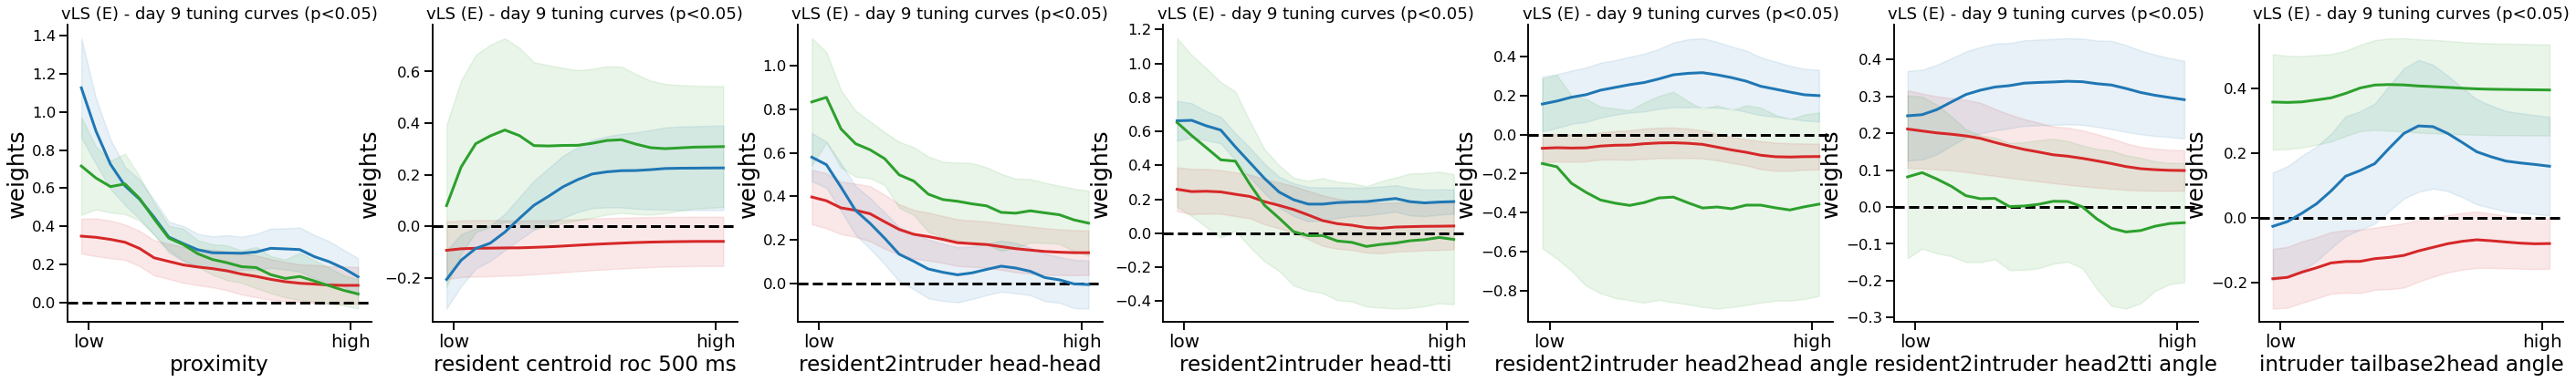

In [96]:
# BETTER FOR GROUP

for region_ind in range(len(maxRegions)):
    indices_significant = list(np.array(np.argwhere(curves_group_better[region_ind,:] == 1)).flatten())
    count_significant = len(indices_significant)
    if count_significant > 0:
        fig, axes = plt.subplots(nrows=1, ncols=count_significant, figsize=(7 * count_significant, 6))
        if count_significant == 1:
            feature_ind = 0
            axes.set_title(f'{maxRegions[region_ind]} - day 9 tuning curves (p<0.05)')
            axes.axhline(0, color = 'black', ls = 'dashed', linewidth=3)

            w_agg = W_map_group[indices_agg,region_ind, indices_significant[feature_ind], 1:]
            axes.plot(w_agg.mean(axis=0), color='tab:red', label=f'Agg', linewidth=3)
            axes.fill_between(range(20), w_agg.mean(axis=0) - 2 * w_agg.std(axis=0), w_agg.mean(axis=0) + 2 * w_agg.std(axis=0), alpha=0.1, color='tab:red')#cmapRed.to_rgba(Nday_ind/1.5+4)) 
                    
            w_obs = W_map_group[indices_obs,region_ind, indices_significant[feature_ind], 1:]
            axes.plot(w_obs.mean(axis=0), color='tab:blue', label=f'Obs', linewidth=3)
            axes.fill_between(range(20), w_obs.mean(axis=0) - 2 * w_obs.std(axis=0), w_obs.mean(axis=0) + 2 * w_obs.std(axis=0), alpha=0.1, color='tab:blue')#cmapRed.to_rgba(Nday_ind/1.5+4)) 
                    
            w_toy = W_map_group[indices_toy,region_ind, indices_significant[feature_ind], 1:]
            # axes[b,c].scatter(-1, weightsAllToy_Days[:,region_ind, feature_ind, 0, Nday_last].mean(axis=0), label=f'Toy', linewidth=3)
            axes.plot(w_toy.mean(axis=0), color='tab:green', label=f'Toy', linewidth=3)
            axes.fill_between(range(20), w_toy.mean(axis=0) - 2 * w_toy.std(axis=0), w_toy.mean(axis=0) + 2 * w_toy.std(axis=0), alpha=0.1, color='tab:green')#cmapRed.to_rgba(Nday_ind/1.5+4)) 

            axes.set_xticks([0.5,18.5],['low','high'], size=20)
            axes.set_ylabel('weights', size=25)
            # axes.set_title(f'{maxRegions[region_ind]} - Day 9 (CD1)', weight='bold', size=25)
            axes.spines[['right', 'top']].set_visible(False)
            axes.set_xlabel(featuresList[indices_significant[feature_ind]],size=23)
        else:
            for feature_ind in range(count_significant):
                # print(featuresList[feature_ind])
                axes[feature_ind].set_title(f'{maxRegions[region_ind]} - day 9 tuning curves (p<0.05)')
                axes[feature_ind].axhline(0, color = 'black', ls = 'dashed', linewidth=3)

                w_agg = W_map_group[indices_agg,region_ind, indices_significant[feature_ind], 1:]
                axes[feature_ind].plot(w_agg.mean(axis=0), color='tab:red', label=f'Agg', linewidth=3)
                axes[feature_ind].fill_between(range(20), w_agg.mean(axis=0) - 2 * w_agg.std(axis=0), w_agg.mean(axis=0) + 2 * w_agg.std(axis=0), alpha=0.1, color='tab:red')#cmapRed.to_rgba(Nday_ind/1.5+4)) 
                    
                w_obs = W_map_group[indices_obs,region_ind, indices_significant[feature_ind], 1:]
                axes[feature_ind].plot(w_obs.mean(axis=0), color='tab:blue', label=f'Obs', linewidth=3)
                axes[feature_ind].fill_between(range(20), w_obs.mean(axis=0) - 2 * w_obs.std(axis=0), w_obs.mean(axis=0) + 2 * w_obs.std(axis=0), alpha=0.1, color='tab:blue')#cmapRed.to_rgba(Nday_ind/1.5+4)) 
                    
                w_toy = W_map_group[indices_toy,region_ind, indices_significant[feature_ind], 1:]
                # axes[b,c].scatter(-1, weightsAllToy_Days[:,region_ind, feature_ind, 0, Nday_last].mean(axis=0), label=f'Toy', linewidth=3)
                axes[feature_ind].plot(w_toy.mean(axis=0), color='tab:green', label=f'Toy', linewidth=3)
                axes[feature_ind].fill_between(range(20), w_toy.mean(axis=0) - 2 * w_toy.std(axis=0), w_toy.mean(axis=0) + 2 * w_toy.std(axis=0), alpha=0.1, color='tab:green')#cmapRed.to_rgba(Nday_ind/1.5+4)) 

                axes[feature_ind].set_xticks([0.5,18.5],['low','high'], size=20)
                axes[feature_ind].set_ylabel('weights', size=25)
                # axes.set_title(f'{maxRegions[region_ind]} - Day 9 (CD1)', weight='bold', size=25)
                axes[feature_ind].spines[['right', 'top']].set_visible(False)
                axes[feature_ind].set_xlabel(featuresList[indices_significant[feature_ind]],size=23)
            plt.show()
    

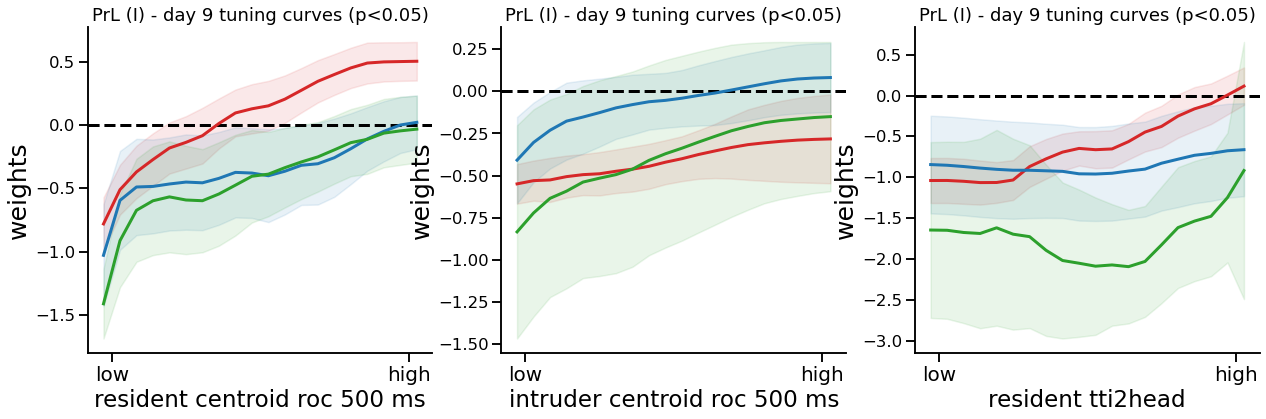

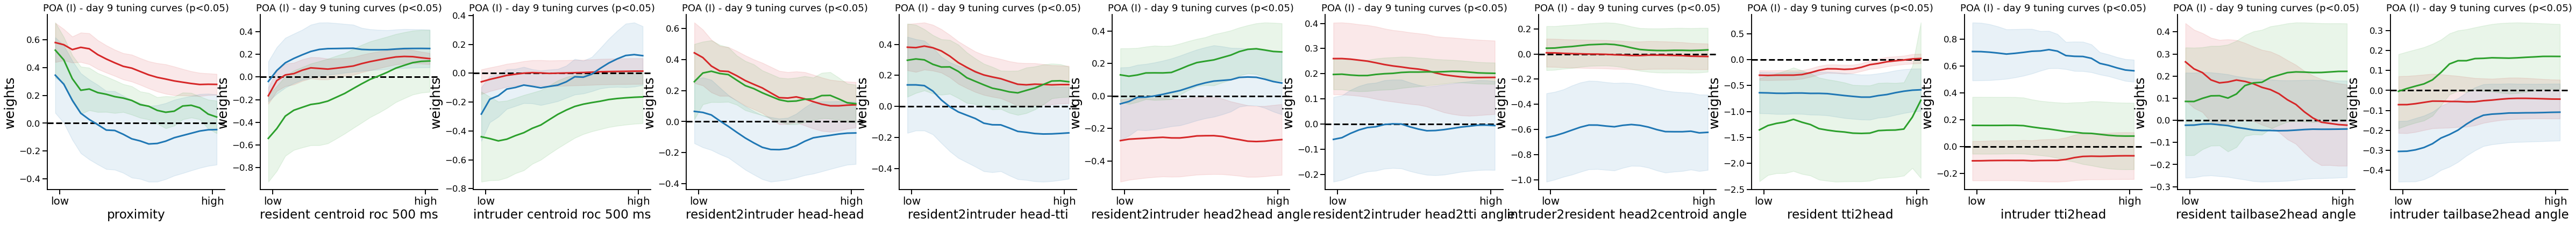

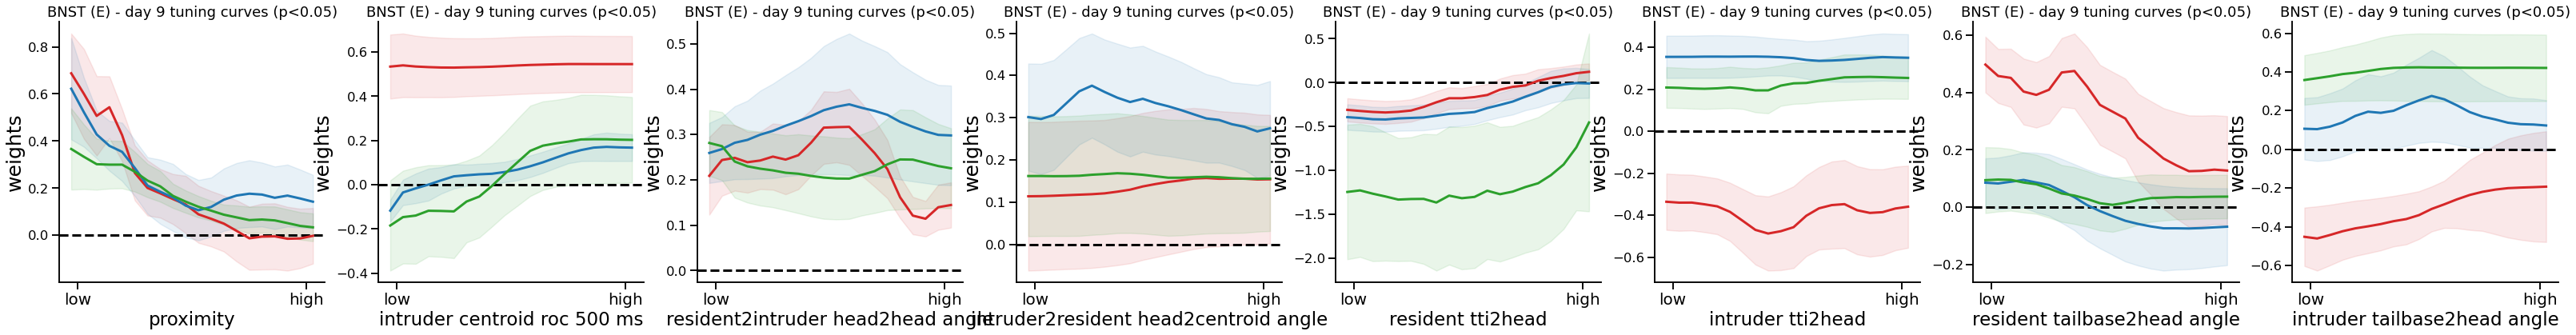

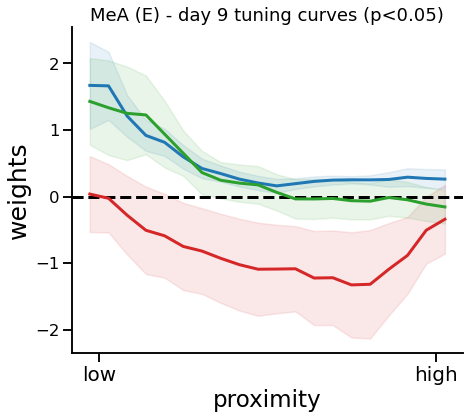

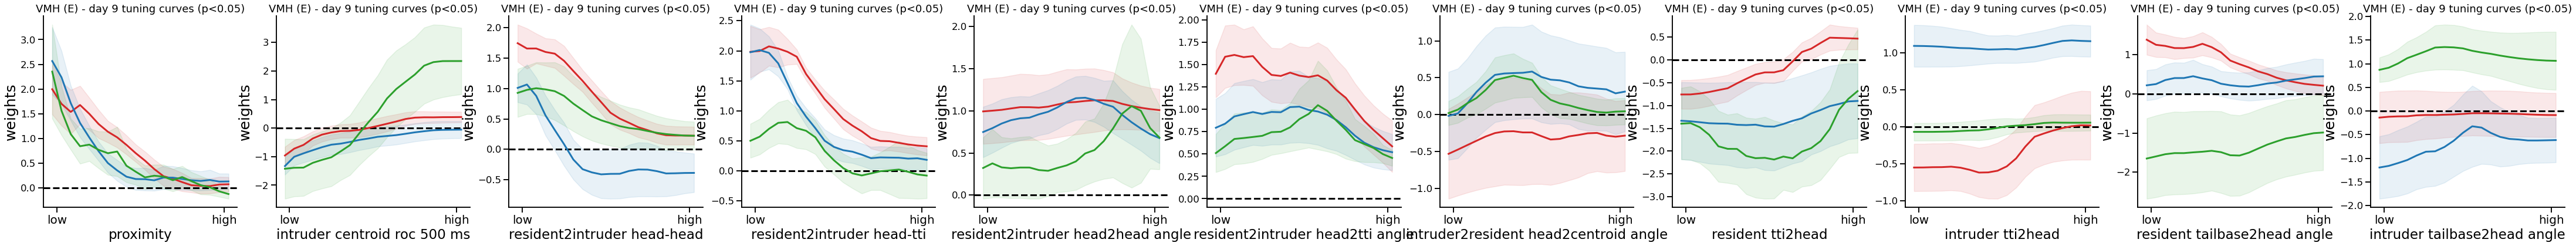

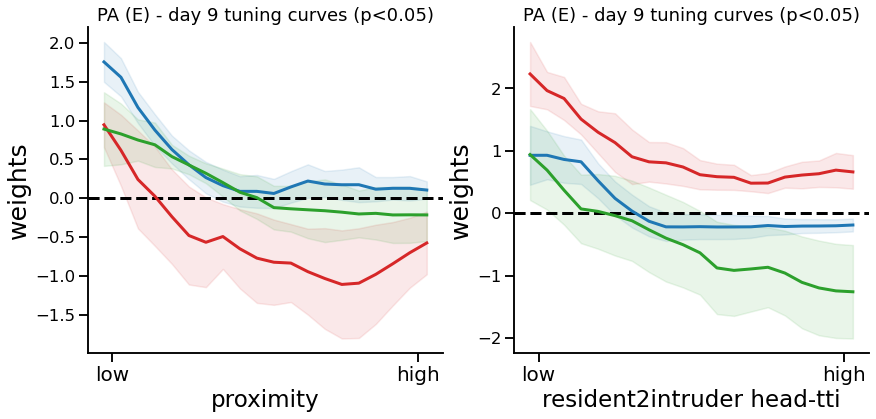

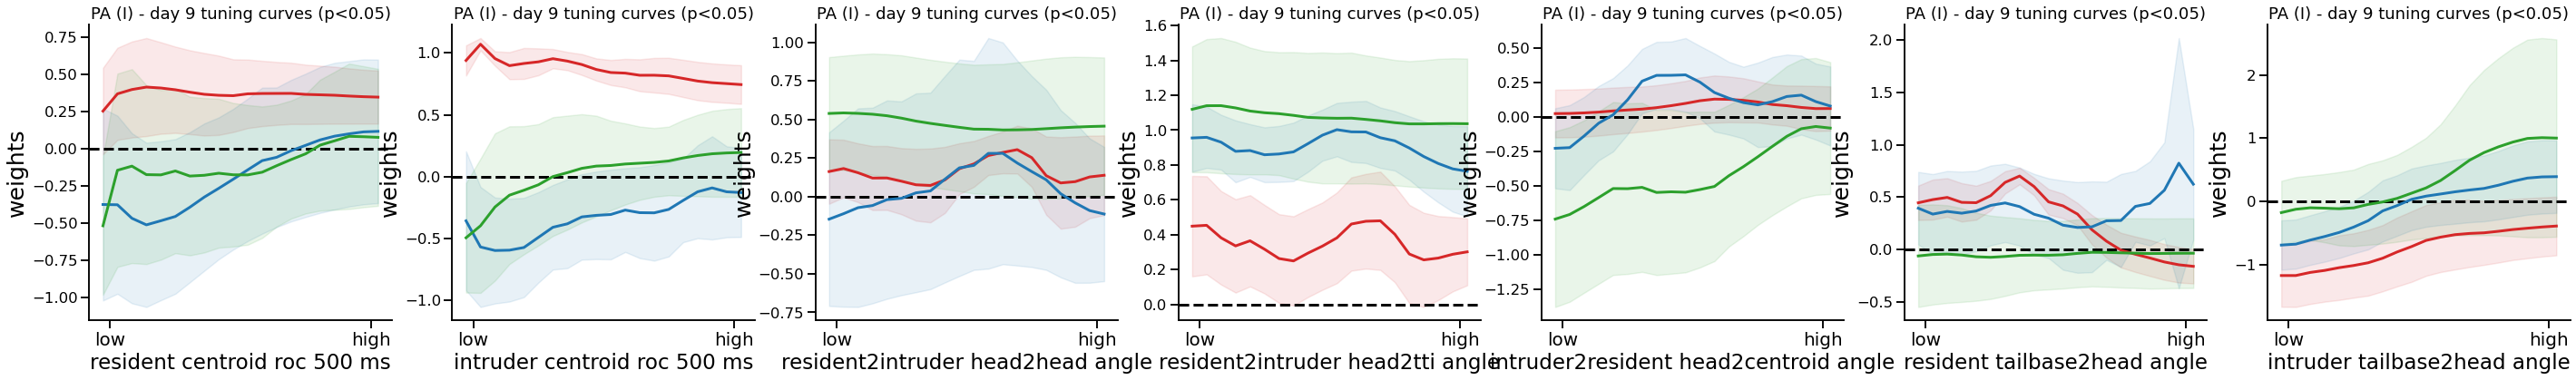

In [97]:
# BETTER FOR GLOBAL

for region_ind in range(len(maxRegions)):
    indices_significant = list(np.array(np.argwhere(curves_global_better[region_ind,:] == 1)).flatten())
    count_significant = len(indices_significant)
    if count_significant > 0:
        fig, axes = plt.subplots(nrows=1, ncols=count_significant, figsize=(7 * count_significant, 6))
        if count_significant == 1:
            feature_ind = 0
            axes.set_title(f'{maxRegions[region_ind]} - day 9 tuning curves (p<0.05)')
            axes.axhline(0, color = 'black', ls = 'dashed', linewidth=3)

            w_agg = W_map_group[indices_agg,region_ind, indices_significant[feature_ind], 1:]
            axes.plot(w_agg.mean(axis=0), color='tab:red', label=f'Agg', linewidth=3)
            axes.fill_between(range(20), w_agg.mean(axis=0) - 2 * w_agg.std(axis=0), w_agg.mean(axis=0) + 2 * w_agg.std(axis=0), alpha=0.1, color='tab:red')#cmapRed.to_rgba(Nday_ind/1.5+4)) 
                    
            w_obs = W_map_group[indices_obs,region_ind, indices_significant[feature_ind], 1:]
            axes.plot(w_obs.mean(axis=0), color='tab:blue', label=f'Obs', linewidth=3)
            axes.fill_between(range(20), w_obs.mean(axis=0) - 2 * w_obs.std(axis=0), w_obs.mean(axis=0) + 2 * w_obs.std(axis=0), alpha=0.1, color='tab:blue')#cmapRed.to_rgba(Nday_ind/1.5+4)) 
                    
            w_toy = W_map_group[indices_toy,region_ind, indices_significant[feature_ind], 1:]
            # axes[b,c].scatter(-1, weightsAllToy_Days[:,region_ind, feature_ind, 0, Nday_last].mean(axis=0), label=f'Toy', linewidth=3)
            axes.plot(w_toy.mean(axis=0), color='tab:green', label=f'Toy', linewidth=3)
            axes.fill_between(range(20), w_toy.mean(axis=0) - 2 * w_toy.std(axis=0), w_toy.mean(axis=0) + 2 * w_toy.std(axis=0), alpha=0.1, color='tab:green')#cmapRed.to_rgba(Nday_ind/1.5+4)) 

            axes.set_xticks([0.5,18.5],['low','high'], size=20)
            axes.set_ylabel('weights', size=25)
            # axes.set_title(f'{maxRegions[region_ind]} - Day 9 (CD1)', weight='bold', size=25)
            axes.spines[['right', 'top']].set_visible(False)
            axes.set_xlabel(featuresList[indices_significant[feature_ind]],size=23)
        else:
            for feature_ind in range(count_significant):
                # print(featuresList[feature_ind])
                axes[feature_ind].set_title(f'{maxRegions[region_ind]} - day 9 tuning curves (p<0.05)')
                axes[feature_ind].axhline(0, color = 'black', ls = 'dashed', linewidth=3)

                w_agg = W_map_group[indices_agg,region_ind, indices_significant[feature_ind], 1:]
                axes[feature_ind].plot(w_agg.mean(axis=0), color='tab:red', label=f'Agg', linewidth=3)
                axes[feature_ind].fill_between(range(20), w_agg.mean(axis=0) - 2 * w_agg.std(axis=0), w_agg.mean(axis=0) + 2 * w_agg.std(axis=0), alpha=0.1, color='tab:red')#cmapRed.to_rgba(Nday_ind/1.5+4)) 
                    
                w_obs = W_map_group[indices_obs,region_ind, indices_significant[feature_ind], 1:]
                axes[feature_ind].plot(w_obs.mean(axis=0), color='tab:blue', label=f'Obs', linewidth=3)
                axes[feature_ind].fill_between(range(20), w_obs.mean(axis=0) - 2 * w_obs.std(axis=0), w_obs.mean(axis=0) + 2 * w_obs.std(axis=0), alpha=0.1, color='tab:blue')#cmapRed.to_rgba(Nday_ind/1.5+4)) 
                    
                w_toy = W_map_group[indices_toy,region_ind, indices_significant[feature_ind], 1:]
                # axes[b,c].scatter(-1, weightsAllToy_Days[:,region_ind, feature_ind, 0, Nday_last].mean(axis=0), label=f'Toy', linewidth=3)
                axes[feature_ind].plot(w_toy.mean(axis=0), color='tab:green', label=f'Toy', linewidth=3)
                axes[feature_ind].fill_between(range(20), w_toy.mean(axis=0) - 2 * w_toy.std(axis=0), w_toy.mean(axis=0) + 2 * w_toy.std(axis=0), alpha=0.1, color='tab:green')#cmapRed.to_rgba(Nday_ind/1.5+4)) 

                axes[feature_ind].set_xticks([0.5,18.5],['low','high'], size=20)
                axes[feature_ind].set_ylabel('weights', size=25)
                # axes.set_title(f'{maxRegions[region_ind]} - Day 9 (CD1)', weight='bold', size=25)
                axes[feature_ind].spines[['right', 'top']].set_visible(False)
                axes[feature_ind].set_xlabel(featuresList[indices_significant[feature_ind]],size=23)
            plt.show()

In [102]:
# significance test for day 9 - done separately for each region and feature
curves_group_better = np.zeros((len(maxRegions), len(featuresList))).astype(int)
curves_global_better = np.zeros((len(maxRegions), len(featuresList))).astype(int)
count = 0
for feature_ind in featuresInterest_index:
    # print(featuresList[feature_ind])
    for region_ind in range(len(maxRegions)):
        # print(maxRegions[region_ind])
        
        # CHECKHOW NANS ARE HANDLED
        # print((r2_animal_test_all[anim, region_ind, feature_ind]))
        # print((r2_animal_test_group[:, region_ind, feature_ind]))

        # # r2 testing
        # t, p = stats.ttest_rel(r2_animal_test_all[indices_agg, region_ind, feature_ind],r2_animal_test_group[indices_agg, region_ind, feature_ind])
        # # t, p = stats.ttest_rel(r2_animal_test_all[indices_agg, region_ind, feature_ind],r2_animal_test_group[indices_agg, region_ind, feature_ind], alternative='less')
        # if (p < 0.05): # r2 (error) for r2_animal_test_all if t > 0
        #     count += 1
        # # print(t)
        #     # print(featuresList[feature_ind])
        #     # print(maxRegions[region_ind])
        #     print('r2 t = ',np.round(t,3))
        #     print('Global model: r2 = ', r2_animal_test_all[:, region_ind, feature_ind].mean())
        #     print('Group model: r2 = ', r2_animal_test_group[:, region_ind, feature_ind].mean())
        #     curves_significant[region_ind,feature_ind] = 1
            
        
        # mse testing
        # t, p = stats.ttest_rel(mse_animal_test_all[:, region_ind, feature_ind],mse_animal_test_group[:, region_ind, feature_ind])
        t, p = stats.ttest_rel(mse_animal_test_all[:, region_ind, feature_ind],mse_animal_test_group[:, region_ind, feature_ind], alternative='greater')
        # print(t)
        if (p<0.05): 
            print('mse t = ',np.round(t,3))
            print(mse_animal_test_all[:, region_ind, feature_ind].mean())
            print(mse_animal_test_group[:, region_ind, feature_ind].mean())
            curves_group_better[region_ind,feature_ind] = 1
        
        t, p = stats.ttest_rel(mse_animal_test_all[:, region_ind, feature_ind],mse_animal_test_group[:, region_ind, feature_ind], alternative='less')
        # print(t)
        if (p<0.05): 
            print('mse t = ',np.round(t,3))
            print(mse_animal_test_all[:, region_ind, feature_ind].mean())
            print(mse_animal_test_group[:, region_ind, feature_ind].mean())
            curves_global_better[region_ind,feature_ind] = 1

print(curves_group_better.sum())
print(curves_global_better.sum())

mse t =  2.6
0.6726129122681774
0.6351527459011709
mse t =  -4.151
0.45666486381626886
0.4758997720309582
mse t =  -2.14
0.433875034949675
0.4593596099470136
mse t =  -2.371
4.280794530277384
4.410336791843911
mse t =  -2.259
3.8727295104211787
3.965873170270732
mse t =  -2.139
3.1896070160179075
3.324744591483328
mse t =  -2.431
1.1218409819362358
1.1460793955666218
mse t =  2.151
0.6865770009228699
0.6610511946138549
mse t =  -1.775
1.3854698486082322
1.4181335921082583
mse t =  -3.432
0.46287194397313325
0.4793362021359808
mse t =  -1.909
0.44626582793321745
0.46162283616177285
mse t =  -2.38
2.1599192183976217
2.227212446862124
mse t =  -2.274
1.1785264718336752
1.2004048500522169
mse t =  1.896
0.6847745351480886
0.6663915620300326
mse t =  -1.781
1.3830262489704048
1.4167149574144875
mse t =  -3.346
0.468778265923969
0.48384209687986873
mse t =  -2.354
0.447524393791079
0.466985793834686
mse t =  -3.061
3.990014371323578
4.062646094905498
mse t =  -3.2
2.1616262432617153
2.221443

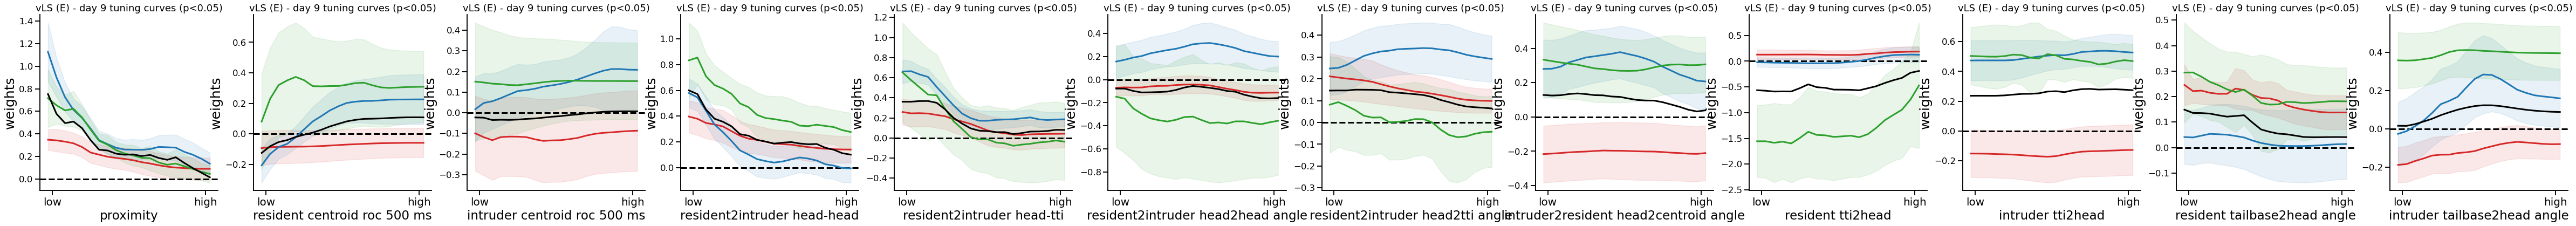

In [107]:
# BETTER FOR GROUP

for region_ind in range(len(maxRegions)):
    indices_significant = list(np.array(np.argwhere(curves_group_better[region_ind,:] == 1)).flatten())
    count_significant = len(indices_significant)
    if count_significant > 0:
        fig, axes = plt.subplots(nrows=1, ncols=count_significant, figsize=(7 * count_significant, 6))
        if count_significant == 1:
            feature_ind = 0
            axes.set_title(f'{maxRegions[region_ind]} - day 9 tuning curves (p<0.05)')
            axes.axhline(0, color = 'black', ls = 'dashed', linewidth=3)

            w_agg = W_map_group[indices_agg,region_ind, indices_significant[feature_ind], 1:]
            axes.plot(w_agg.mean(axis=0), color='tab:red', label=f'Agg', linewidth=3)
            axes.fill_between(range(20), w_agg.mean(axis=0) - 2 * w_agg.std(axis=0), w_agg.mean(axis=0) + 2 * w_agg.std(axis=0), alpha=0.1, color='tab:red')#cmapRed.to_rgba(Nday_ind/1.5+4)) 
                    
            w_obs = W_map_group[indices_obs,region_ind, indices_significant[feature_ind], 1:]
            axes.plot(w_obs.mean(axis=0), color='tab:blue', label=f'Obs', linewidth=3)
            axes.fill_between(range(20), w_obs.mean(axis=0) - 2 * w_obs.std(axis=0), w_obs.mean(axis=0) + 2 * w_obs.std(axis=0), alpha=0.1, color='tab:blue')#cmapRed.to_rgba(Nday_ind/1.5+4)) 
                    
            w_toy = W_map_group[indices_toy,region_ind, indices_significant[feature_ind], 1:]
            # axes[b,c].scatter(-1, weightsAllToy_Days[:,region_ind, feature_ind, 0, Nday_last].mean(axis=0), label=f'Toy', linewidth=3)
            axes.plot(w_toy.mean(axis=0), color='tab:green', label=f'Toy', linewidth=3)
            axes.fill_between(range(20), w_toy.mean(axis=0) - 2 * w_toy.std(axis=0), w_toy.mean(axis=0) + 2 * w_toy.std(axis=0), alpha=0.1, color='tab:green')#cmapRed.to_rgba(Nday_ind/1.5+4)) 

            axes.set_xticks([0.5,18.5],['low','high'], size=20)
            axes.set_ylabel('weights', size=25)
            # axes.set_title(f'{maxRegions[region_ind]} - Day 9 (CD1)', weight='bold', size=25)
            axes.spines[['right', 'top']].set_visible(False)
            axes.set_xlabel(featuresList[indices_significant[feature_ind]],size=23)
        else:
            for feature_ind in range(count_significant):
                # print(featuresList[feature_ind])
                axes[feature_ind].set_title(f'{maxRegions[region_ind]} - day 9 tuning curves (p<0.05)')
                axes[feature_ind].axhline(0, color = 'black', ls = 'dashed', linewidth=3)

                w_agg = W_map_group[indices_agg,region_ind, indices_significant[feature_ind], 1:]
                axes[feature_ind].plot(w_agg.mean(axis=0), color='tab:red', label=f'Agg', linewidth=3)
                axes[feature_ind].fill_between(range(20), w_agg.mean(axis=0) - 2 * w_agg.std(axis=0), w_agg.mean(axis=0) + 2 * w_agg.std(axis=0), alpha=0.1, color='tab:red')#cmapRed.to_rgba(Nday_ind/1.5+4)) 
                    
                w_obs = W_map_group[indices_obs,region_ind, indices_significant[feature_ind], 1:]
                axes[feature_ind].plot(w_obs.mean(axis=0), color='tab:blue', label=f'Obs', linewidth=3)
                axes[feature_ind].fill_between(range(20), w_obs.mean(axis=0) - 2 * w_obs.std(axis=0), w_obs.mean(axis=0) + 2 * w_obs.std(axis=0), alpha=0.1, color='tab:blue')#cmapRed.to_rgba(Nday_ind/1.5+4)) 
                    
                w_toy = W_map_group[indices_toy,region_ind, indices_significant[feature_ind], 1:]
                # axes[b,c].scatter(-1, weightsAllToy_Days[:,region_ind, feature_ind, 0, Nday_last].mean(axis=0), label=f'Toy', linewidth=3)
                axes[feature_ind].plot(w_toy.mean(axis=0), color='tab:green', label=f'Toy', linewidth=3)
                axes[feature_ind].fill_between(range(20), w_toy.mean(axis=0) - 2 * w_toy.std(axis=0), w_toy.mean(axis=0) + 2 * w_toy.std(axis=0), alpha=0.1, color='tab:green')#cmapRed.to_rgba(Nday_ind/1.5+4)) 

                axes[feature_ind].plot(W_map_all[:,region_ind, indices_significant[feature_ind], 1:].mean(axis=0), color='black', label=f'global', linewidth=3)

                axes[feature_ind].set_xticks([0.5,18.5],['low','high'], size=20)
                axes[feature_ind].set_ylabel('weights', size=25)
                # axes.set_title(f'{maxRegions[region_ind]} - Day 9 (CD1)', weight='bold', size=25)
                axes[feature_ind].spines[['right', 'top']].set_visible(False)
                axes[feature_ind].set_xlabel(featuresList[indices_significant[feature_ind]],size=23)
            plt.show()
    

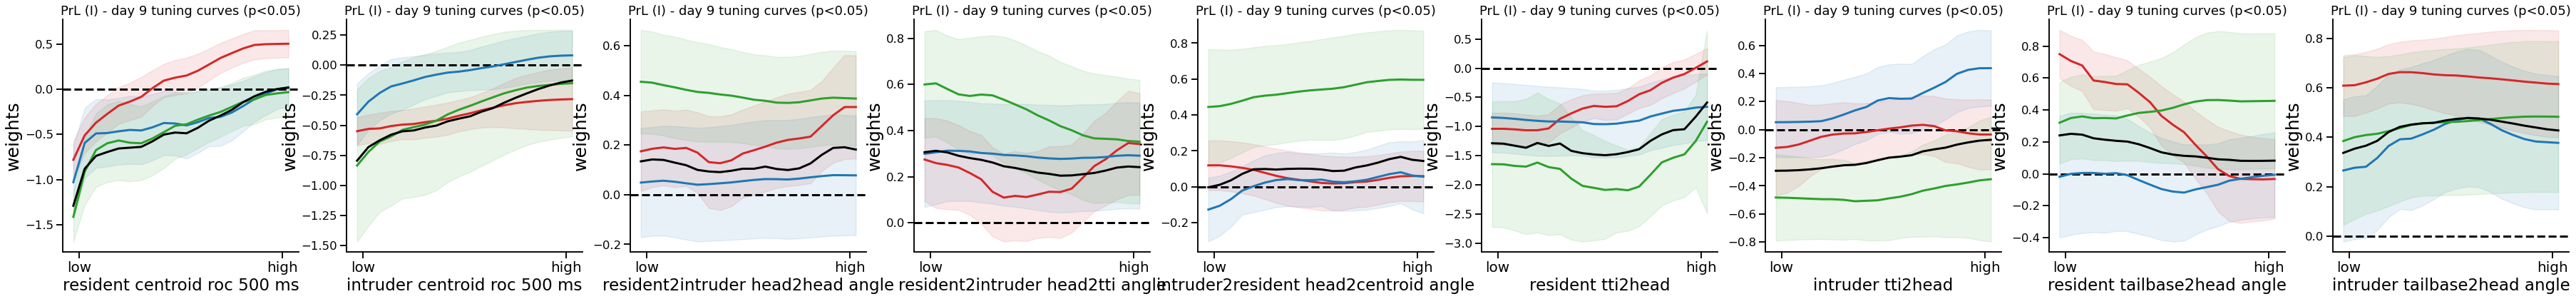

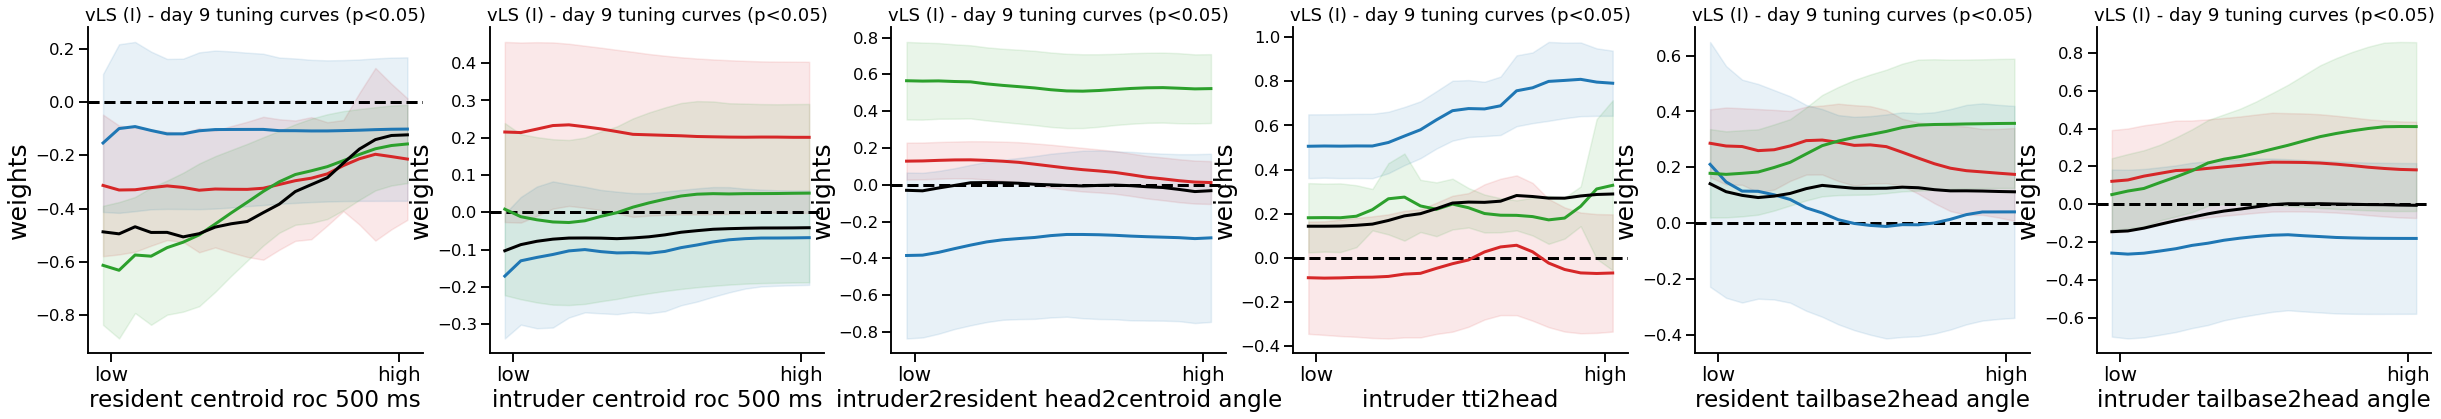

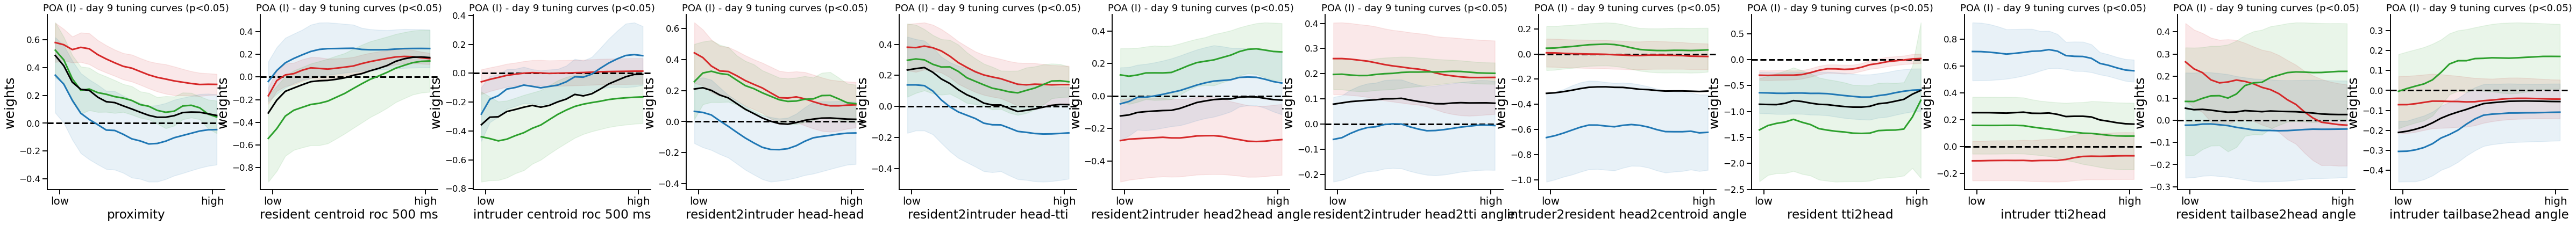

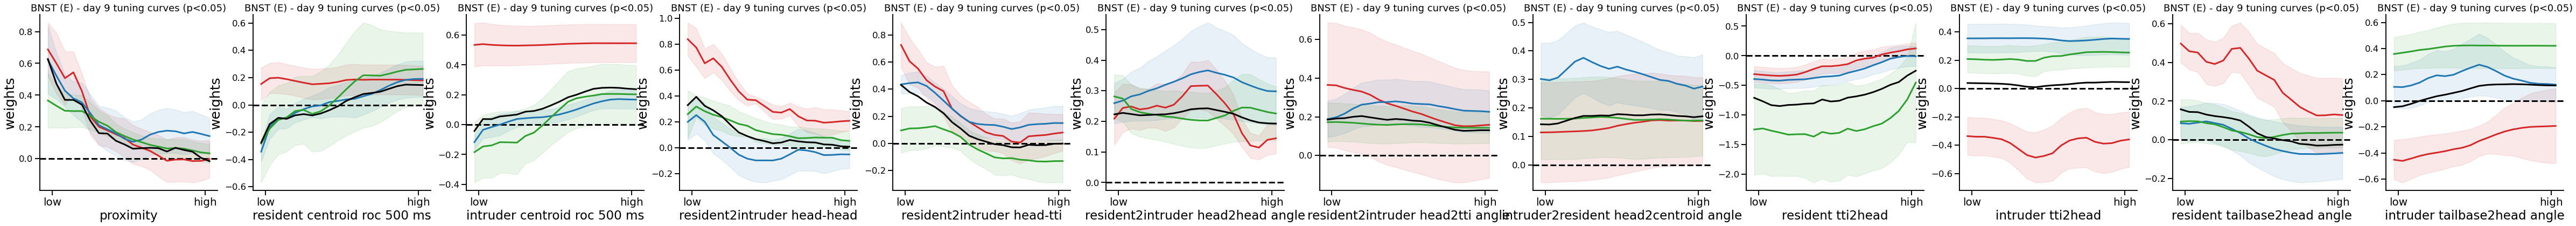

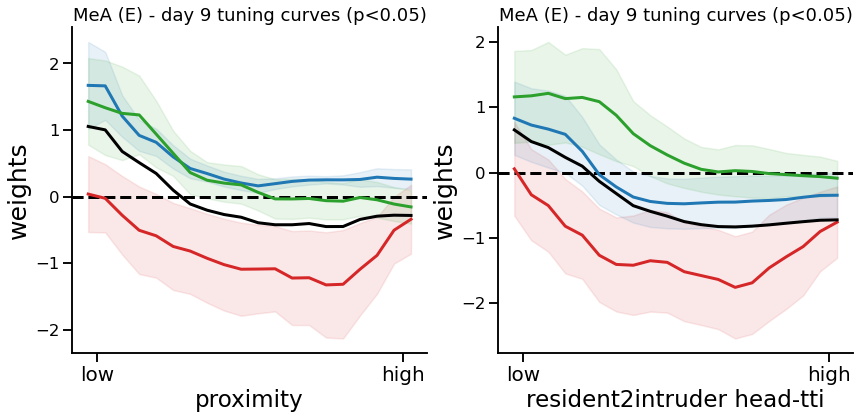

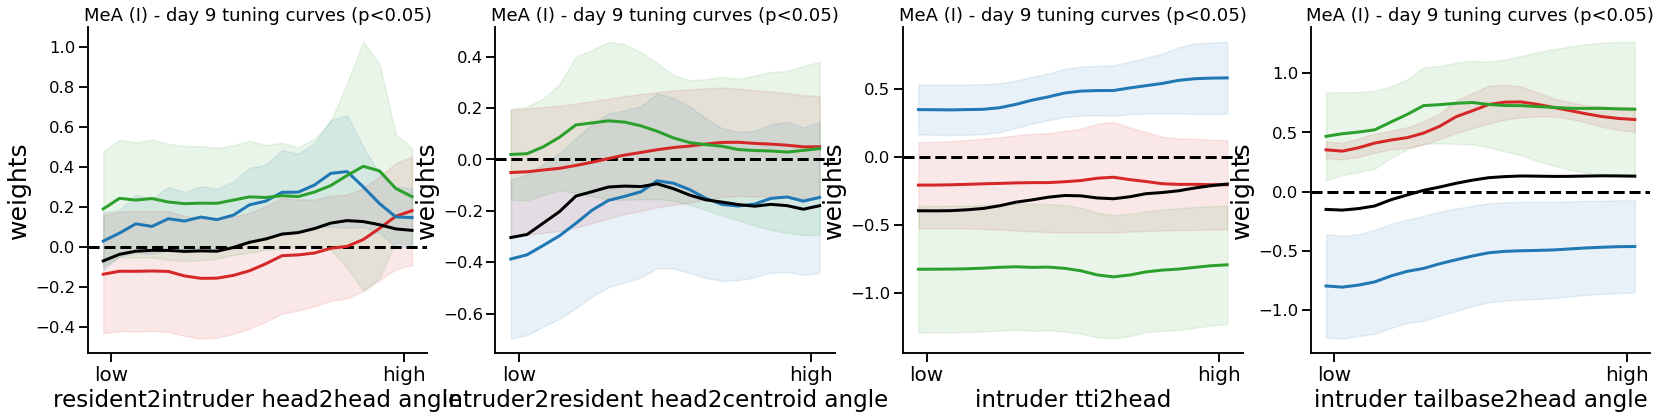

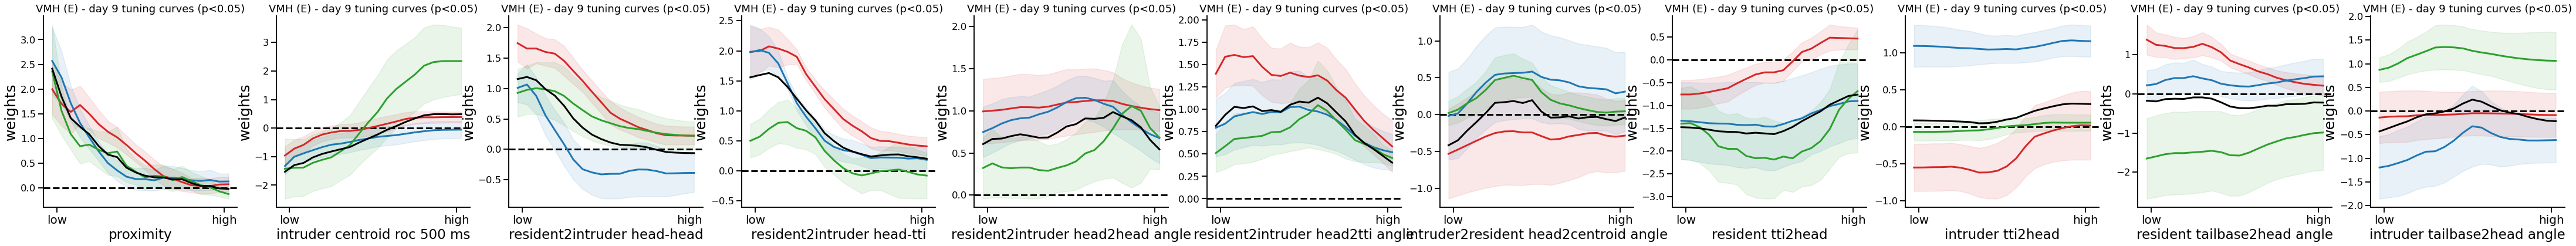

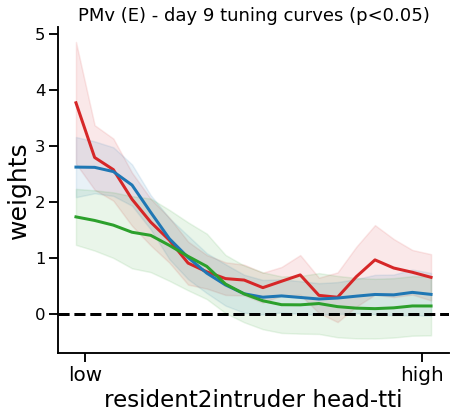

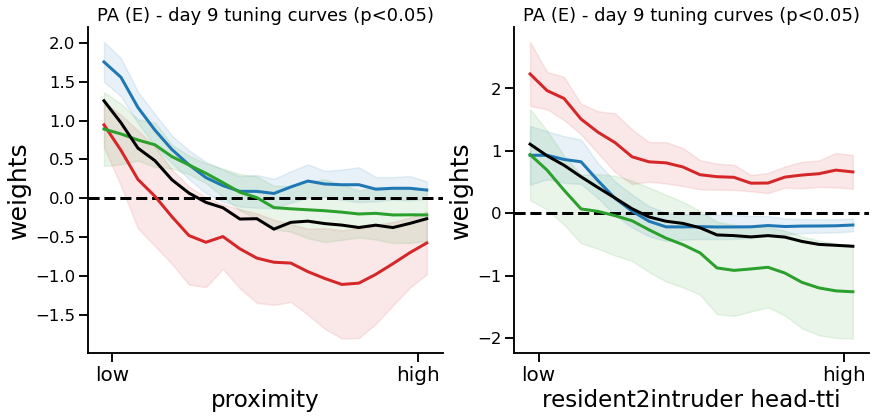

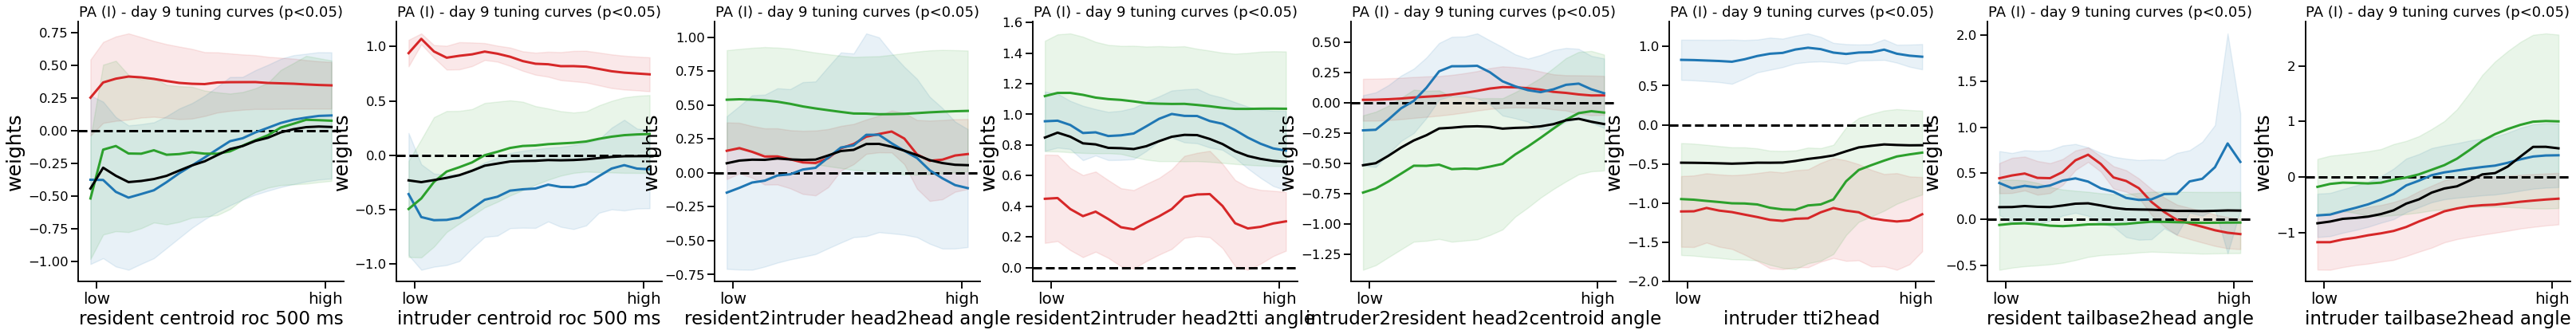

In [108]:
# BETTER FOR GROUP

for region_ind in range(len(maxRegions)):
    indices_significant = list(np.array(np.argwhere(curves_global_better[region_ind,:] == 1)).flatten())
    count_significant = len(indices_significant)
    if count_significant > 0:
        fig, axes = plt.subplots(nrows=1, ncols=count_significant, figsize=(7 * count_significant, 6))
        if count_significant == 1:
            feature_ind = 0
            axes.set_title(f'{maxRegions[region_ind]} - day 9 tuning curves (p<0.05)')
            axes.axhline(0, color = 'black', ls = 'dashed', linewidth=3)

            w_agg = W_map_group[indices_agg,region_ind, indices_significant[feature_ind], 1:]
            axes.plot(w_agg.mean(axis=0), color='tab:red', label=f'Agg', linewidth=3)
            axes.fill_between(range(20), w_agg.mean(axis=0) - 2 * w_agg.std(axis=0), w_agg.mean(axis=0) + 2 * w_agg.std(axis=0), alpha=0.1, color='tab:red')#cmapRed.to_rgba(Nday_ind/1.5+4)) 
                    
            w_obs = W_map_group[indices_obs,region_ind, indices_significant[feature_ind], 1:]
            axes.plot(w_obs.mean(axis=0), color='tab:blue', label=f'Obs', linewidth=3)
            axes.fill_between(range(20), w_obs.mean(axis=0) - 2 * w_obs.std(axis=0), w_obs.mean(axis=0) + 2 * w_obs.std(axis=0), alpha=0.1, color='tab:blue')#cmapRed.to_rgba(Nday_ind/1.5+4)) 
                    
            w_toy = W_map_group[indices_toy,region_ind, indices_significant[feature_ind], 1:]
            # axes[b,c].scatter(-1, weightsAllToy_Days[:,region_ind, feature_ind, 0, Nday_last].mean(axis=0), label=f'Toy', linewidth=3)
            axes.plot(w_toy.mean(axis=0), color='tab:green', label=f'Toy', linewidth=3)
            axes.fill_between(range(20), w_toy.mean(axis=0) - 2 * w_toy.std(axis=0), w_toy.mean(axis=0) + 2 * w_toy.std(axis=0), alpha=0.1, color='tab:green')#cmapRed.to_rgba(Nday_ind/1.5+4)) 

            axes.set_xticks([0.5,18.5],['low','high'], size=20)
            axes.set_ylabel('weights', size=25)
            # axes.set_title(f'{maxRegions[region_ind]} - Day 9 (CD1)', weight='bold', size=25)
            axes.spines[['right', 'top']].set_visible(False)
            axes.set_xlabel(featuresList[indices_significant[feature_ind]],size=23)
        else:
            for feature_ind in range(count_significant):
                # print(featuresList[feature_ind])
                axes[feature_ind].set_title(f'{maxRegions[region_ind]} - day 9 tuning curves (p<0.05)')
                axes[feature_ind].axhline(0, color = 'black', ls = 'dashed', linewidth=3)

                w_agg = W_map_group[indices_agg,region_ind, indices_significant[feature_ind], 1:]
                axes[feature_ind].plot(w_agg.mean(axis=0), color='tab:red', label=f'Agg', linewidth=3)
                axes[feature_ind].fill_between(range(20), w_agg.mean(axis=0) - 2 * w_agg.std(axis=0), w_agg.mean(axis=0) + 2 * w_agg.std(axis=0), alpha=0.1, color='tab:red')#cmapRed.to_rgba(Nday_ind/1.5+4)) 
                    
                w_obs = W_map_group[indices_obs,region_ind, indices_significant[feature_ind], 1:]
                axes[feature_ind].plot(w_obs.mean(axis=0), color='tab:blue', label=f'Obs', linewidth=3)
                axes[feature_ind].fill_between(range(20), w_obs.mean(axis=0) - 2 * w_obs.std(axis=0), w_obs.mean(axis=0) + 2 * w_obs.std(axis=0), alpha=0.1, color='tab:blue')#cmapRed.to_rgba(Nday_ind/1.5+4)) 
                    
                w_toy = W_map_group[indices_toy,region_ind, indices_significant[feature_ind], 1:]
                # axes[b,c].scatter(-1, weightsAllToy_Days[:,region_ind, feature_ind, 0, Nday_last].mean(axis=0), label=f'Toy', linewidth=3)
                axes[feature_ind].plot(w_toy.mean(axis=0), color='tab:green', label=f'Toy', linewidth=3)
                axes[feature_ind].fill_between(range(20), w_toy.mean(axis=0) - 2 * w_toy.std(axis=0), w_toy.mean(axis=0) + 2 * w_toy.std(axis=0), alpha=0.1, color='tab:green')#cmapRed.to_rgba(Nday_ind/1.5+4)) 

                axes[feature_ind].plot(W_map_all[:,region_ind, indices_significant[feature_ind], 1:].mean(axis=0), color='black', label=f'global', linewidth=3)

                axes[feature_ind].set_xticks([0.5,18.5],['low','high'], size=20)
                axes[feature_ind].set_ylabel('weights', size=25)
                # axes.set_title(f'{maxRegions[region_ind]} - Day 9 (CD1)', weight='bold', size=25)
                axes[feature_ind].spines[['right', 'top']].set_visible(False)
                axes[feature_ind].set_xlabel(featuresList[indices_significant[feature_ind]],size=23)
            plt.show()
    